### Differentially Private GAN-Based federated learning  

In [1]:
!pip install torch  tqdm  torcheval  torchmetrics torchvision matplotlib  opacus flwr torch-fidelity ray[default]


INFO: pip is looking at multiple versions of google-api-core to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.8/531.8 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 86.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 107.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""
Runs DCGAN training with differential privacy.

"""
from __future__ import print_function
import PIL.Image as Image

import argparse
import os
import random

import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.models import inception_v3
from opacus import PrivacyEngine
from tqdm import tqdm
from  torcheval.metrics import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import matplotlib.pyplot as plt
import random


# Parameters (modify these directly instead of command-line args)
class Args:
    data_root = "./data"                   # Path to dataset
    outf = "./output"                      # Output folder
    workers = 2                            # Data loading workers
    batch_size = 32                        # Batch size
    imageSize = 28                         # Image dimension
    nz = 100                               # Latent vector size
    ngf = 64                              # Generator features
    ndf = 64                              # Discriminator features
    epochs = 20                            # Total epochs
    lr = 0.0001                            # Learning rate
    beta1 = 0.5                            # Adam beta1
    ngpu = 1                               # GPUs (0 for CPU)
    target_digit = -1                      # MNIST digit to generate
    disable_dp = False                     # Disable DP?
    sigma = 0.5                          # DP noise multiplier
    max_per_sample_grad_norm = 1.0         # Gradient clipping
    delta = 1e-5                           # DP delta
    device = "cuda" if torch.cuda.is_available() else "cpu"
    manualSeed = 100
    netG = ""
    netD = ""
    secure_rng=False
    nd = 5
    compute_fid = False
    compute_inception = True
    label_smoothing = True
opt = Args()

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

Random Seed:  100


In [3]:
try:
    dataset = dset.MNIST(
        root=opt.data_root,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(opt.imageSize,interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        ),
    )
    if (opt.target_digit!= -1):
        idx = dataset.targets == opt.target_digit
        dataset.targets = dataset.targets[idx]
        dataset.data = dataset.data[idx]
except ValueError:
    print("Cannot load dataset")

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=int(opt.workers),
    batch_size=opt.batch_size,
    shuffle=False,
)

nc = 1 ## number of channels
device = torch.device(opt.device)
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Maximum achievable epsilon (privacy budget)


In [30]:
alphas = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)) ## default range for alpha momentum in opacus
alphas =" ".join(map(str, alphas))
sample_rate = opt.batch_size / len(dataset)

!git clone https://github.com/pytorch/opacus.git
%cd opacus
!pip install -r requirements.txt
!pip install -e .
%cd .. 

fatal: destination path 'opacus' already exists and is not an empty directory.
/kaggle/working/opacus
Obtaining file:///kaggle/working/opacus
  Preparing metadata (setup.py) ... done
  Attempting uninstall: opacus
    Found existing installation: opacus 1.5.2
    Uninstalling opacus-1.5.2:
      Successfully uninstalled opacus-1.5.2
  Running setup.py develop for opacus
/kaggle/working


In [17]:
## to run this script , opacus must be installed from source (above cell )
!python -m opacus.scripts.compute_dp_sgd_privacy --epochs=$opt.epochs --delta=1e-5 --sample-rate $sample_rate --noise-multiplier $opt.sigma --alphas $alphas

DP-SGD with
	sampling rate = 0.0533%,
	noise_multiplier = 0.5,
	iterated over 37500 steps,
satisfies differential privacy with
	epsilon = 6.06,
	delta = 1e-05.
The optimal alpha is 3.1.


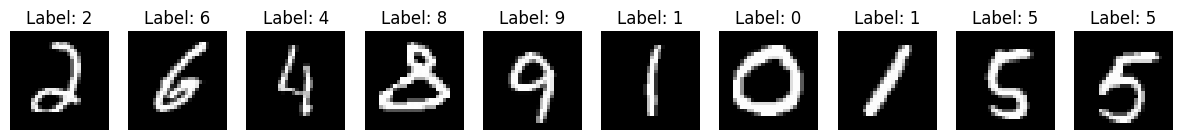

In [31]:

num_samples = 10

# Randomly sample some indices
random_indices = random.sample(range(len(dataset)), num_samples)

# Create a plot
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    # Get the image and its label
    image, label = dataset[idx]

    # Plot each image
    ax = axes[i]
    ax.imshow(image.squeeze(), cmap='gray')  # .squeeze() removes the single-channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis('off')  # Turn off axis

plt.show()

In [4]:

# Define the improved network
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * (opt.imageSize//8)**2, 1000)  # Adjusted for correct dimensions
        self.fc2 = nn.Linear(1000, 10)  # Assuming 10 classes (for MNIST)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)  # 64x64 -> 32x32 -- 28x28 -> 14x14
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)  # 32x32 -> 16x16 -- 14x14 -> 7x7
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)  # 16x16 -> 8x8 -- 7x7 -> 3x3 
        x = x.view(x.size(0), -1)  # Flatten: 128 * 8 * 8 = 8192 -- 128 * 3 * 3
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Train a Cliassifier for mnist (10 class ) instead of Inception Module 

In [5]:
####
#Script for training a classifier which will be used in inception_score
#enough to run for the first time  
####



# Load datasets
train_dataset = dset.MNIST(
    root='./data',
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(opt.imageSize,interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

eval_dataset = dset.MNIST(
    root='./data',
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(opt.imageSize,interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

# Create DataLoader for the training and evaluation datasets
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_loader =  torch.utils.data.DataLoader(eval_dataset, batch_size=64, shuffle=False)

# Model, optimizer, and loss function
classifier = Classifier().to(device)
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.AdamW(classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(classifier_optimizer, step_size=5, gamma=0.1)

# Training Loop with Accuracy Evaluation
num_epochs = 5
best_accuracy = 0.0

inception_score_metric = InceptionScore(classifier,normalize=False,splits=1)

for epoch in range(num_epochs):
    classifier.train()  # Set classifier to training mode
    running_loss = 0.0

    # Training phase
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        classifier_optimizer.zero_grad()

        # Forward pass
        output = classifier(data)

        # Calculate loss
        loss = classifier_criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        classifier_optimizer.step()

        running_loss += loss.item()
        # Print stats every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}")

    # Evaluation phase: Calculate accuracy on the validation set
    classifier.eval()  # Set classifier to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients for evaluation
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            # Forward pass
            output = classifier(data)

            # Get predictions
            _, predicted = torch.max(output, 1)

            # Calculate correct predictions
            total += target.size(0)
            correct += (predicted == target).sum().item()


    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy on eval dataset: {accuracy:.2f}%")

    # Update learning rate
    scheduler.step()

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(classifier.state_dict(), 'best_model.pth')
    ## to test noise input with inception_score_metric  
    inception_score_metric = InceptionScore(classifier,normalize=False,splits=10)

    # generated_images = (torch.rand(100, 1, opt.imageSize, opt.imageSize) +1)/2
    # generated_images=generated_images.to(device)
    # inception_score = inception_score_metric(generated_images)
    inception_score = inception_score_metric(all_data)

    print(f"Inception Score at epoch {epoch}: mu,sigma {inception_score[0].detach().cpu().numpy().tolist(),inception_score[1].detach().cpu().numpy().tolist()}")
print(f"Best Accuracy: {best_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch [1/5], Batch [1/938], Loss: 2.4064
Epoch [1/5], Batch [101/938], Loss: 0.1219
Epoch [1/5], Batch [201/938], Loss: 0.0371
Epoch [1/5], Batch [301/938], Loss: 0.0209
Epoch [1/5], Batch [401/938], Loss: 0.0861
Epoch [1/5], Batch [501/938], Loss: 0.1811
Epoch [1/5], Batch [601/938], Loss: 0.0770
Epoch [1/5], Batch [701/938], Loss: 0.0421
Epoch [1/5], Batch [801/938], Loss: 0.0822
Epoch [1/5], Batch [901/938], Loss: 0.0327
Epoch [1/5], Average Loss: 0.1425
Epoch [1/5], Accuracy on eval dataset: 98.48%
Inception Score at epoch 0: mu,sigma (9.456503868103027, 0.028890108689665794)
Epoch [2/5], Batch [1/938], Loss: 0.1011
Epoch [2/5], Batch [101/938], Loss: 0.0124
Epoch [2/5], Batch [201/938], Loss: 0.0119
Epoch [2/5], Batch [301/938], Loss: 0.0114
Epoch [2/5], Batch [401/938], Loss: 0.2064
Epoch [2/5], Batch [501/938], Loss: 0.0347
Epoch [2/5], Batch [601/938], Loss: 0.0473
Epoch [2/5], Batch [701/938], Loss: 0.0417
Epoch [2/5], Batch [801/938], Loss: 0.0399
Epoch [2/5], Batch [901/938]

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu,img_size=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.img_size = img_size
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.GroupNorm(min(32, out_feat), out_feat))
            layers.append(nn.ReLU(True))
            return layers
        
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.GroupNorm(min(32, ndf * 8), ndf * 8),
            nn.ReLU(True),
            *block(ngf * 8, ngf * 4),  # (ngf*4) x 8 x 8
            *block(ngf * 4, ngf * 2),  # (ngf*2) x 16 x 16
            *block(ngf * 2, ngf),  # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # (nc) x 64 x 64
            nn.Tanh()
        )
        if self.img_size == 28:
            # Adjust for 28x28 images
            self.main = nn.Sequential(
                nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
                nn.GroupNorm(min(32, ngf * 4), ngf * 4),
                nn.ReLU(True),
                *block(ngf * 4, ngf * 2),  # (ngf*2) x 8 x 8
                *block(ngf * 2, ngf * 1),  # (ngf) x 16 x 16
                nn.ConvTranspose2d(ngf, nc, 2, 2, 2, bias=False),  # (nc) x 28 x 28
                nn.Tanh()
            )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
class Discriminator(nn.Module):
    def __init__(self, ngpu,img_size=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.img_size = img_size
        def block(in_feat, out_feat, normalize=True):
                layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
                if normalize:
                    layers.append(nn.GroupNorm(min(32, out_feat), out_feat))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            *block(nc, ndf, normalize=False),  # (ndf) x 32 x 32
            *block(ndf, ndf * 2),  # (ndf*2) x 16 x 16
            *block(ndf * 2, ndf * 4),  # (ndf*4) x 8 x 8
            *block(ndf * 4, ndf * 8),  # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 1 x 1 x 1
            nn.Sigmoid()
        )
        if self.img_size == 28:
            # Adjust for 28x28 images
            self.main = nn.Sequential(
                *block(nc, ndf * 2, normalize=False),  # (ndf*2) x 14 x 14
                *block(ndf * 2, ndf * 4),  # (ndf*4) x 7 x 7
                nn.Conv2d(ndf * 4, 1, 7, 1, 0, bias=False),  # 1 x 1 x 1
                nn.Sigmoid()
            )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

##FID score
if opt.compute_fid:
  latent_dim=opt.nz
  def interpolate(batch):
      arr = []
      for img in batch:
          pil_img = transforms.ToPILImage()(img)
          resized_img = pil_img.resize((299,299), Image.BILINEAR)
          arr.append(transforms.ToTensor()(resized_img))
      return torch.stack(arr)
  ### not been used for mnist dataset
  # Load the Inception v3 model pretrained on ImageNet (299x299x3)
  # requires interpolation
  inception_model = inception_v3(pretrained=True, transform_input=False)
  inception_model.eval()
  for param in inception_model.parameters():
        param.requires_grad = False
  fid_metric = FrechetInceptionDistance(model=inception_model,device=device)
  ## must put below lines of code in which i%100==0
  # fid_metric.update(interpolate(real_data.repeat(1,3, 1, 1)), is_real=True)
  # fid_metric.update(interpolate(fake.repeat(1,3, 1, 1)), is_real=False)
  # fid_score = fid_metric.compute()
  # print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], FID Score: {fid_score.item()}")

if opt.compute_inception:
  classifier = Classifier()
  try:
      classifier.load_state_dict(torch.load('best_model.pth',weights_only=True))  # Corrected line
  except:
    classifier.load_state_dict(torch.load('/kaggle/input/best_model.pth/pytorch/default/1/best_model.pth',weights_only=True))  # Corrected line

  classifier.eval()
  for param in classifier.parameters():
    param.requires_grad = False
  inception_score = InceptionScore(classifier)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [38]:
def plot(eval_matric):
    Gloss = [j.cpu().detach().numpy() for j in eval_matric[0][0]]
    Dloss = [j.cpu().detach().numpy() for j in eval_matric[0][1]]
    Incep_score = eval_matric[0][2]
    best_fake = [j.cpu().detach() for j in eval_matric[0][3]]

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Fake Images best with best IC score")
    fake_grid = vutils.make_grid(best_fake, normalize=True).cpu()
    plt.imshow(numpy.transpose(fake_grid, (1, 2, 0)))
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(Gloss,label="G")
    plt.plot(Dloss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title("Inception Score")
    plt.plot(Incep_score,label="Inception")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [9]:

FIXED_NOISE = torch.randn(opt.batch_size, nz, 1, 1, device=device)
REAL_LABEL = 1.0
FAKE_LABEL = 0.0
if opt.label_smoothing :
    REAL_LABEL = 0.9
    FAKE_LABEL = 0.1

def train_gan(generator, discriminator, trainloader, epochs,evaulation):

    optimizerD = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
    criterion = nn.BCELoss()
    best_Inception = 1.0
    if not opt.disable_dp:
        privacy_engine = PrivacyEngine(secure_mode=opt.secure_rng)
    
        discriminator, optimizerD, trainloader = privacy_engine.make_private(
            module=discriminator,
            optimizer=optimizerD,
            data_loader=trainloader,
            noise_multiplier=opt.sigma,
            max_grad_norm=opt.max_per_sample_grad_norm,
        )

    G_losses,D_losses,incep_scores = [],[],[]
    
    for epoch in range(epochs):
        data_bar = tqdm(trainloader)
        for i, data in enumerate(data_bar, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            generator.train()
            discriminator.train()
            optimizerD.zero_grad(set_to_none=True)
    
            real_data = data[0].to(device)
            batch_size = real_data.size(0)
    
            # train with real
            label_true = torch.full((batch_size,), REAL_LABEL, device=device)
            output = discriminator(real_data)
            errD_real = criterion(output, label_true)
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = generator(noise)
            label_fake = torch.full((batch_size,), FAKE_LABEL, device=device)
            output = discriminator(fake.detach())
            errD_fake = criterion(output, label_fake)
    
            # below, you actually have two backward passes happening under the hood
            # which opacus happens to treat as a recursive network
            # and therefore doesn't add extra noise for the fake samples
            # noise for fake samples would be unnecesary to preserve privacy
    
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()
            optimizerD.zero_grad(set_to_none=True)
    
            D_G_z1 = output.mean().item()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            if (i%opt.nd != 0):
                continue
            
            optimizerG.zero_grad()
    
            label_g = torch.full((batch_size,), REAL_LABEL, device=device)
            output_g = discriminator(fake)
            errG = criterion(output_g, label_g)
            errG.backward()
            D_G_z2 = output_g.mean().item()
            optimizerG.step()

            if i % 1000 == 0:
                generator.eval()
                if not opt.disable_dp:
                    epsilon = privacy_engine.accountant.get_epsilon(delta=opt.delta)
                    data_bar.set_description(
                        f"epoch: {epoch}, Loss_D: {errD.item()} "
                        f"Loss_G: {errG.item()} D(x): {D_x} "
                        f"D(G(z)): {D_G_z1}/{D_G_z2}"
                        "(ε = %.2f, δ = %.2f)" % (epsilon, opt.delta)
                    )
                else:
                    data_bar.set_description(
                        f"epoch: {epoch}, Loss_D: {errD.item()} "
                        f"Loss_G: {errG.item()} D(x): {D_x} "
                        f"D(G(z)): {D_G_z1}/{D_G_z2}"
                    )
                G_losses.append(errG)
                D_losses.append(errD)
                vutils.save_image(
                    real_data, "%s/real_samples.png" % opt.outf, normalize=True
                )
                fake_sample = generator(FIXED_NOISE)
                vutils.save_image(
                    fake_sample.detach(),
                    "%s/fake_samples_epoch_%03d.png" % (opt.outf, epoch),
                    normalize=True,
                )
    
        # do checkpointing
        generator.eval()
        noise = torch.randn(batch_size*10, nz, 1, 1, device=device)
        fake_distributed = generator(noise)
        incep = inception_score(fake_distributed.detach().cpu())
        if (incep[0] > best_Inception):
            best_Inception= incep[0]
            best_fake = fake_sample ##(bath_size )
        print(f"Inception Score at epoch {epoch}: mu,sigma {incep[0].numpy().tolist(),incep[1].numpy().tolist()}")
        incep_scores.append(incep[0].item().tolist()
        torch.save(netG.state_dict(), "%s/netG_epoch_%d.pth" % (opt.outf, epoch))
        torch.save(netD.state_dict(), "%s/netD_epoch_%d.pth" % (opt.outf, epoch))
    evaulation.append(  [G_losses,D_losses,incep_scores, best_fake])


### Without dp ( epsilon -> INf)

epoch: 0, Loss_D: 0.025459373369812965 Loss_G: 6.0659871101379395 D(x): 0.9883896112442017 D(G(z)): 0.013354646973311901/0.004358185455203056: 100%|██████████| 1875/1875 [00:16<00:00, 113.57it/s]


Inception Score at epoch 0: mu,sigma (1.0071603059768677, 0.003148967633023858)


epoch: 1, Loss_D: 0.08508841693401337 Loss_G: 4.020578384399414 D(x): 0.9465831518173218 D(G(z)): 0.011274918913841248/0.03156234696507454: 100%|██████████| 1875/1875 [00:16<00:00, 115.48it/s]


Inception Score at epoch 1: mu,sigma (1.0411548614501953, 0.04333700239658356)


epoch: 2, Loss_D: 0.24787676334381104 Loss_G: 3.3378353118896484 D(x): 0.9082151651382446 D(G(z)): 0.08908402919769287/0.06442800164222717: 100%|██████████| 1875/1875 [00:16<00:00, 113.40it/s]


Inception Score at epoch 2: mu,sigma (2.0486409664154053, 0.3647953271865845)


epoch: 3, Loss_D: 0.7064518928527832 Loss_G: 1.8090416193008423 D(x): 0.7524368762969971 D(G(z)): 0.12490686774253845/0.259952187538147: 100%|██████████| 1875/1875 [00:16<00:00, 114.46it/s]


Inception Score at epoch 3: mu,sigma (2.540361166000366, 0.5814522504806519)


epoch: 4, Loss_D: 0.5485886931419373 Loss_G: 3.2540111541748047 D(x): 0.8568061590194702 D(G(z)): 0.22962889075279236/0.10407604277133942: 100%|██████████| 1875/1875 [00:16<00:00, 114.45it/s]


Inception Score at epoch 4: mu,sigma (2.725184202194214, 0.6227850317955017)


epoch: 5, Loss_D: 0.6295243501663208 Loss_G: 2.081021785736084 D(x): 0.7209393382072449 D(G(z)): 0.15963172912597656/0.17616689205169678: 100%|██████████| 1875/1875 [00:16<00:00, 115.09it/s]


Inception Score at epoch 5: mu,sigma (2.7234580516815186, 0.8644030094146729)


epoch: 6, Loss_D: 0.8145468831062317 Loss_G: 2.7043352127075195 D(x): 0.8575313091278076 D(G(z)): 0.3720431327819824/0.12054960429668427: 100%|██████████| 1875/1875 [00:16<00:00, 113.67it/s]


Inception Score at epoch 6: mu,sigma (2.617088556289673, 0.5612165331840515)


epoch: 7, Loss_D: 0.8913971185684204 Loss_G: 1.154237151145935 D(x): 0.5824494361877441 D(G(z)): 0.10556606203317642/0.4734790325164795: 100%|██████████| 1875/1875 [00:16<00:00, 115.40it/s]


Inception Score at epoch 7: mu,sigma (2.6523149013519287, 0.722474992275238)


epoch: 8, Loss_D: 1.013739824295044 Loss_G: 1.2802141904830933 D(x): 0.5911146402359009 D(G(z)): 0.17912283539772034/0.36773937940597534: 100%|██████████| 1875/1875 [00:16<00:00, 114.04it/s]


Inception Score at epoch 8: mu,sigma (3.2127749919891357, 0.8132858276367188)


epoch: 9, Loss_D: 0.9885134100914001 Loss_G: 1.7740195989608765 D(x): 0.5978288650512695 D(G(z)): 0.17079925537109375/0.26897549629211426: 100%|██████████| 1875/1875 [00:16<00:00, 116.33it/s]


Inception Score at epoch 9: mu,sigma (3.0022339820861816, 0.4845128655433655)


epoch: 10, Loss_D: 1.0965007543563843 Loss_G: 1.3417574167251587 D(x): 0.595421314239502 D(G(z)): 0.15850035846233368/0.3644603490829468: 100%|██████████| 1875/1875 [00:16<00:00, 112.62it/s]


Inception Score at epoch 10: mu,sigma (3.2882845401763916, 0.552228569984436)


epoch: 11, Loss_D: 0.7490295171737671 Loss_G: 1.6613330841064453 D(x): 0.7100614309310913 D(G(z)): 0.20631740987300873/0.25663289427757263: 100%|██████████| 1875/1875 [00:16<00:00, 111.64it/s]


Inception Score at epoch 11: mu,sigma (2.666243076324463, 0.7733269333839417)


epoch: 12, Loss_D: 0.8980497121810913 Loss_G: 2.193950653076172 D(x): 0.757327675819397 D(G(z)): 0.3350597023963928/0.16684454679489136: 100%|██████████| 1875/1875 [00:16<00:00, 115.12it/s]


Inception Score at epoch 12: mu,sigma (3.2360997200012207, 0.4691268503665924)


epoch: 13, Loss_D: 0.8741288781166077 Loss_G: 1.6187118291854858 D(x): 0.6214375495910645 D(G(z)): 0.15344035625457764/0.2865363359451294: 100%|██████████| 1875/1875 [00:16<00:00, 114.91it/s]


Inception Score at epoch 13: mu,sigma (2.797867774963379, 0.6711274981498718)


epoch: 14, Loss_D: 0.8137083053588867 Loss_G: 2.25119948387146 D(x): 0.8342904448509216 D(G(z)): 0.36622074246406555/0.16038388013839722: 100%|██████████| 1875/1875 [00:16<00:00, 115.25it/s]


Inception Score at epoch 14: mu,sigma (2.840581178665161, 0.6766337156295776)


epoch: 15, Loss_D: 0.791761040687561 Loss_G: 1.6693661212921143 D(x): 0.6584696769714355 D(G(z)): 0.13176867365837097/0.26247990131378174: 100%|██████████| 1875/1875 [00:16<00:00, 114.89it/s]


Inception Score at epoch 15: mu,sigma (3.107769250869751, 0.6913445591926575)


epoch: 16, Loss_D: 0.8303062319755554 Loss_G: 1.7683188915252686 D(x): 0.7046064138412476 D(G(z)): 0.22936522960662842/0.23579531908035278: 100%|██████████| 1875/1875 [00:16<00:00, 116.32it/s]


Inception Score at epoch 16: mu,sigma (2.3155975341796875, 0.5868290662765503)


epoch: 17, Loss_D: 0.859666109085083 Loss_G: 2.5537161827087402 D(x): 0.7744424343109131 D(G(z)): 0.3152450621128082/0.1445520967245102: 100%|██████████| 1875/1875 [00:16<00:00, 116.66it/s]


Inception Score at epoch 17: mu,sigma (3.1524949073791504, 0.717254638671875)


epoch: 18, Loss_D: 1.0076143741607666 Loss_G: 2.4220712184906006 D(x): 0.6853281855583191 D(G(z)): 0.2661607563495636/0.19336290657520294: 100%|██████████| 1875/1875 [00:16<00:00, 114.60it/s]


Inception Score at epoch 18: mu,sigma (2.8569319248199463, 0.6251364946365356)


epoch: 19, Loss_D: 0.9557182788848877 Loss_G: 1.6806951761245728 D(x): 0.6376421451568604 D(G(z)): 0.1915610134601593/0.3069927990436554: 100%|██████████| 1875/1875 [00:16<00:00, 114.43it/s] 


Inception Score at epoch 19: mu,sigma (2.685663938522339, 0.4935058653354645)


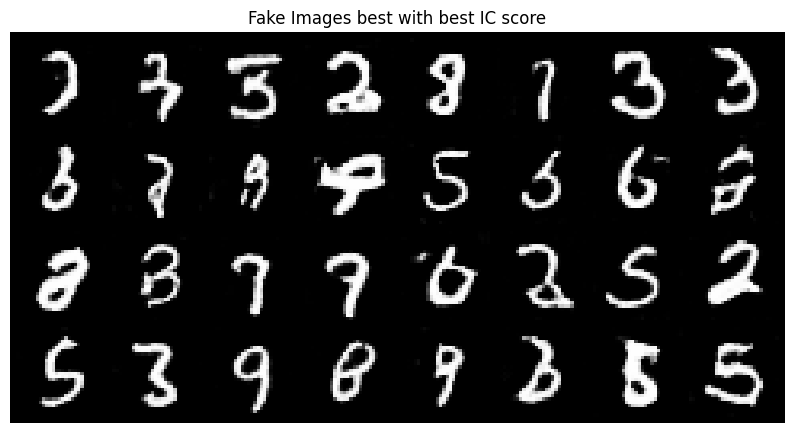

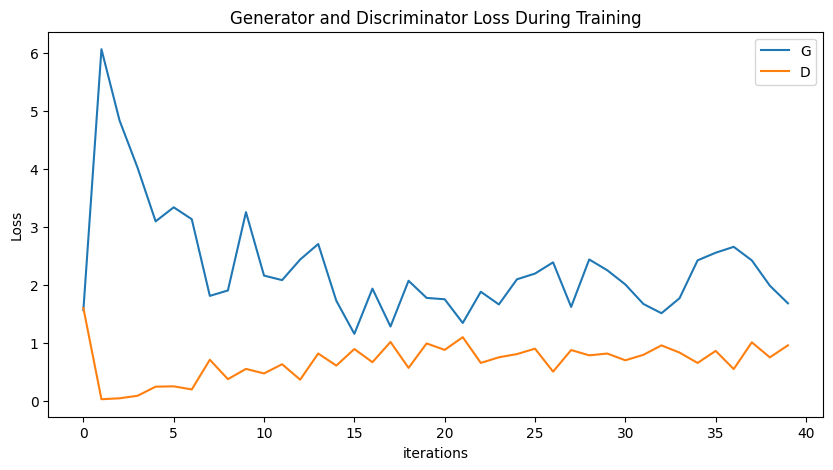

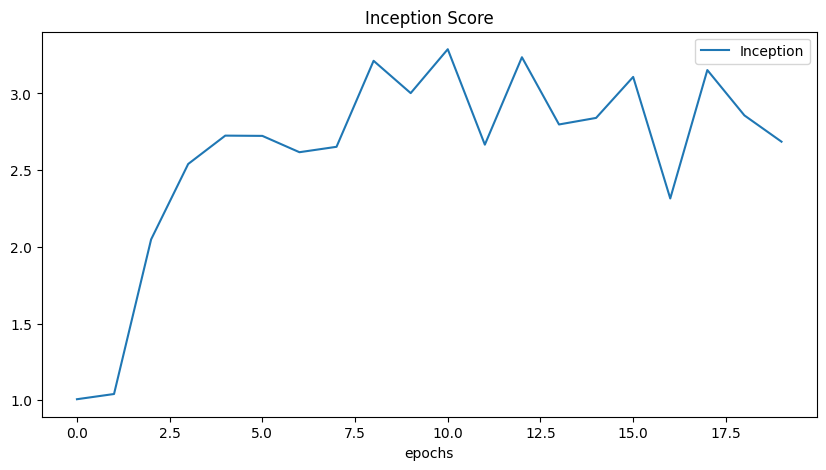

In [39]:
opt.disable_dp = True
opt.nd =2
netG = Generator(ngpu,opt.imageSize)
netG = netG.to(device)

netG.apply(weights_init)

if opt.netG != "":
    netG.load_state_dict(torch.load(opt.netG))
netD = Discriminator(ngpu,opt.imageSize)
netD = netD.to(device)
netD.apply(weights_init)
if opt.netD != "":
    netD.load_state_dict(torch.load(opt.netD))

eval_matric = []
train_gan(netG,netD,dataloader,opt.epochs,eval_matric)
plot(eval_matric)

### Try the same network now with sample differential privacy !

In [40]:

opt.disable_dp = False
opt.nd = 2
netG = Generator(ngpu,opt.imageSize)
netG = netG.to(device)

netG.apply(weights_init)

if opt.netG != "":
    netG.load_state_dict(torch.load(opt.netG))
netD = Discriminator(ngpu,opt.imageSize)
netD = netD.to(device)
netD.apply(weights_init)
if opt.netD != "":
    netD.load_state_dict(torch.load(opt.netD))

eval_matric = []
train_gan(netG,netD,dataloader,opt.epochs,eval_matric)
plot(eval_matric)

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
epoch: 0, Loss_D: 0.7031844854354858 Loss_G: 1.498600721359253 D(x): 0.7252092957496643 D(G(z)): 0.287675678730011/0.230983167886734(ε = 2.32, δ = 0.00): 100%|██████████| 1875/1875 [00:42<00:00, 43.92it/s]


Inception Score at epoch 0: mu,sigma (1.0018471479415894, 0.0013170844176784158)


epoch: 1, Loss_D: 0.8252726197242737 Loss_G: 1.5935654640197754 D(x): 0.6610994935035706 D(G(z)): 0.21565485000610352/0.20412537455558777(ε = 2.82, δ = 0.00): 100%|██████████| 1875/1875 [00:29<00:00, 63.67it/s]


Inception Score at epoch 1: mu,sigma (1.0003999471664429, 0.0003257810603827238)


epoch: 2, Loss_D: 0.8960461616516113 Loss_G: 1.1904658079147339 D(x): 0.6289682388305664 D(G(z)): 0.2747165262699127/0.30498194694519043(ε = 3.09, δ = 0.00): 100%|██████████| 1875/1875 [00:29<00:00, 62.54it/s]


Inception Score at epoch 2: mu,sigma (1.0001933574676514, 0.00014235297567211092)


epoch: 3, Loss_D: 0.8965575695037842 Loss_G: 1.2798866033554077 D(x): 0.6532274484634399 D(G(z)): 0.32858577370643616/0.2784200608730316(ε = 3.29, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 60.89it/s]


Inception Score at epoch 3: mu,sigma (1.0003257989883423, 0.0003609122068155557)


epoch: 4, Loss_D: 0.5647025108337402 Loss_G: 1.9281013011932373 D(x): 0.7626662254333496 D(G(z)): 0.19400514662265778/0.14577613770961761(ε = 3.45, δ = 0.00): 100%|██████████| 1875/1875 [00:29<00:00, 63.78it/s]


Inception Score at epoch 4: mu,sigma (1.0002344846725464, 0.00011132502550026402)


epoch: 5, Loss_D: 0.6566003561019897 Loss_G: 1.972883939743042 D(x): 0.7609080672264099 D(G(z)): 0.25414180755615234/0.1395372748374939(ε = 3.59, δ = 0.00): 100%|██████████| 1875/1875 [00:29<00:00, 63.02it/s] 


Inception Score at epoch 5: mu,sigma (1.0004456043243408, 0.0004674098454415798)


epoch: 6, Loss_D: 0.2703257203102112 Loss_G: 2.3302996158599854 D(x): 0.8958929777145386 D(G(z)): 0.1279374361038208/0.097679503262043(ε = 3.72, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 60.90it/s]  


Inception Score at epoch 6: mu,sigma (1.00002121925354, 2.285742993990425e-05)


epoch: 7, Loss_D: 0.8666343092918396 Loss_G: 1.6759555339813232 D(x): 0.7058085799217224 D(G(z)): 0.2605348229408264/0.1872997283935547(ε = 3.84, δ = 0.00): 100%|██████████| 1875/1875 [00:29<00:00, 64.49it/s] 


Inception Score at epoch 7: mu,sigma (1.0000133514404297, 8.117994184431154e-06)


epoch: 8, Loss_D: 0.7667700052261353 Loss_G: 1.6577850580215454 D(x): 0.7017711997032166 D(G(z)): 0.23718562722206116/0.19073529541492462(ε = 3.95, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 62.04it/s]


Inception Score at epoch 8: mu,sigma (1.0001184940338135, 4.192315100226551e-05)


epoch: 9, Loss_D: 0.9487395882606506 Loss_G: 1.4482849836349487 D(x): 0.6748970746994019 D(G(z)): 0.33887311816215515/0.23510891199111938(ε = 4.05, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 61.78it/s]


Inception Score at epoch 9: mu,sigma (1.0000160932540894, 1.015537873172434e-05)


epoch: 10, Loss_D: 0.5664860010147095 Loss_G: 1.623499870300293 D(x): 0.6982582211494446 D(G(z)): 0.12869493663311005/0.19762901961803436(ε = 4.15, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 61.38it/s]


Inception Score at epoch 10: mu,sigma (1.0010098218917847, 0.0007135985651984811)


epoch: 11, Loss_D: 1.2782585620880127 Loss_G: 1.1828080415725708 D(x): 0.6182246804237366 D(G(z)): 0.4065416157245636/0.3066384494304657(ε = 4.25, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 61.21it/s]


Inception Score at epoch 11: mu,sigma (1.002854824066162, 0.0011453283950686455)


epoch: 12, Loss_D: 1.2603387832641602 Loss_G: 0.8232206702232361 D(x): 0.5531296730041504 D(G(z)): 0.35048362612724304/0.43905502557754517(ε = 4.34, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 62.42it/s]


Inception Score at epoch 12: mu,sigma (1.0004448890686035, 0.00024678243789821863)


epoch: 13, Loss_D: 1.0466065406799316 Loss_G: 1.3222606182098389 D(x): 0.5516574382781982 D(G(z)): 0.18865780532360077/0.26660147309303284(ε = 4.43, δ = 0.00): 100%|██████████| 1875/1875 [00:31<00:00, 59.46it/s]


Inception Score at epoch 13: mu,sigma (1.0051969289779663, 0.004621053580194712)


epoch: 14, Loss_D: 2.082890272140503 Loss_G: 0.5816014409065247 D(x): 0.4271208345890045 D(G(z)): 0.5871753692626953/0.5591604113578796(ε = 4.52, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 60.67it/s] 


Inception Score at epoch 14: mu,sigma (1.0006155967712402, 0.0004736738046631217)


epoch: 15, Loss_D: 1.736060380935669 Loss_G: 0.8124082684516907 D(x): 0.5448611974716187 D(G(z)): 0.5749691128730774/0.4438517987728119(ε = 4.60, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 62.00it/s] 


Inception Score at epoch 15: mu,sigma (1.003662109375, 0.002030758187174797)


epoch: 16, Loss_D: 1.0742368698120117 Loss_G: 0.9964344501495361 D(x): 0.5884577035903931 D(G(z)): 0.32316869497299194/0.3692269027233124(ε = 4.68, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 60.94it/s]


Inception Score at epoch 16: mu,sigma (1.0000035762786865, 3.0710373266629176e-06)


epoch: 17, Loss_D: 0.9605989456176758 Loss_G: 1.7197508811950684 D(x): 0.593490481376648 D(G(z)): 0.1239653155207634/0.17917628586292267(ε = 4.77, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 61.75it/s]


Inception Score at epoch 17: mu,sigma (1.000069499015808, 4.8591398808639497e-05)


epoch: 18, Loss_D: 0.7692456245422363 Loss_G: 2.069812297821045 D(x): 0.7239018082618713 D(G(z)): 0.21051272749900818/0.1262209415435791(ε = 4.84, δ = 0.00): 100%|██████████| 1875/1875 [00:30<00:00, 60.69it/s]


Inception Score at epoch 18: mu,sigma (1.0007143020629883, 0.0004590365570038557)


epoch: 19, Loss_D: 0.2980114221572876 Loss_G: 2.9832074642181396 D(x): 0.8521454334259033 D(G(z)): 0.07261637598276138/0.05068494752049446(ε = 4.92, δ = 0.00): 100%|██████████| 1875/1875 [00:31<00:00, 59.32it/s]

Inception Score at epoch 19: mu,sigma (1.0017457008361816, 0.0011540609411895275)


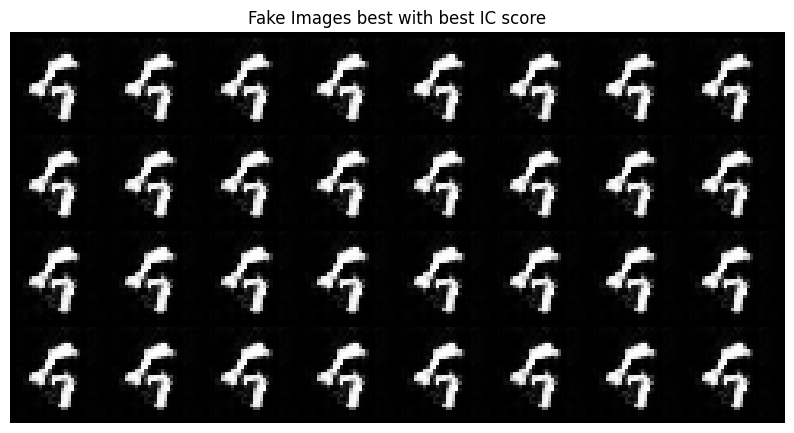

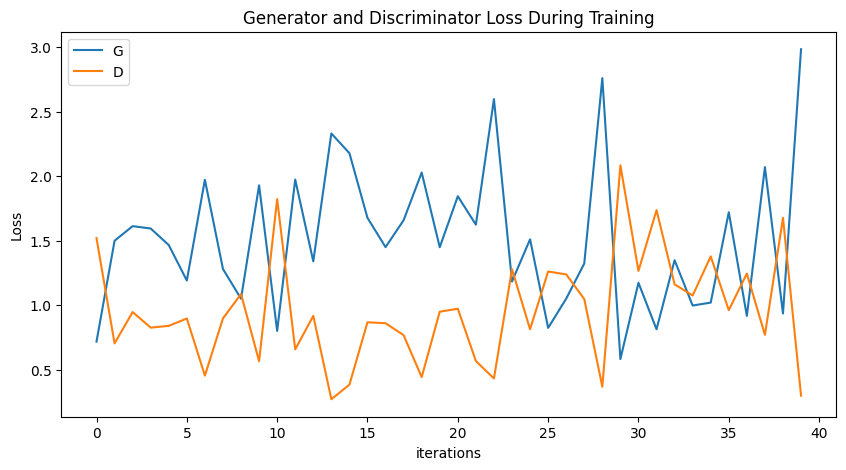

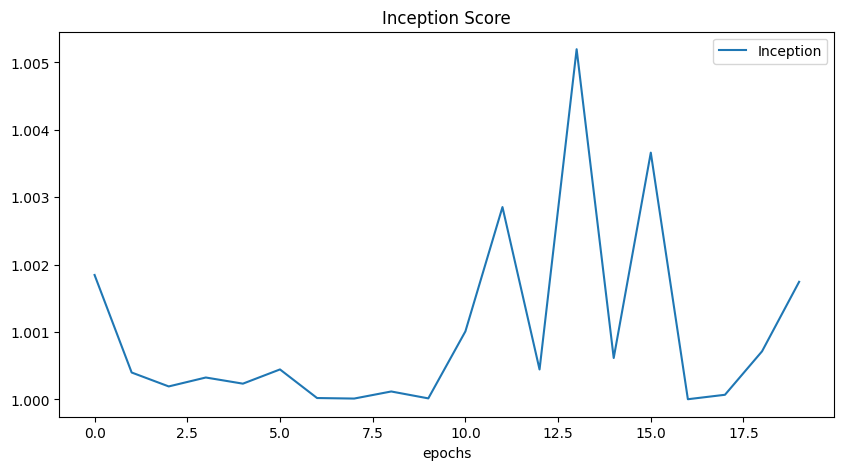

In [42]:
plot(eval_matric)



### different hyper-params (label_smoothing)

epoch: 0, Loss_D: 0.33517909049987793 Loss_G: 2.231731414794922 D(x): 0.8251039981842041 D(G(z)): 0.113863505423069/0.11774127185344696(ε = 2.32, δ = 0.00): 100%|██████████| 1875/1875 [00:25<00:00, 72.42it/s]


Inception Score at epoch 0: mu,sigma (1.0012480020523071, 0.0006161562050692737)


epoch: 1, Loss_D: 0.46168339252471924 Loss_G: 2.0965700149536133 D(x): 0.8174869418144226 D(G(z)): 0.18745304644107819/0.15664830803871155(ε = 2.82, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 71.72it/s]


Inception Score at epoch 1: mu,sigma (1.0122562646865845, 0.010600779205560684)


epoch: 2, Loss_D: 0.7811078429222107 Loss_G: 1.3934050798416138 D(x): 0.7010924220085144 D(G(z)): 0.2928171157836914/0.2927238345146179(ε = 3.09, δ = 0.00): 100%|██████████| 1875/1875 [00:25<00:00, 72.63it/s]


Inception Score at epoch 2: mu,sigma (1.0174050331115723, 0.008256107568740845)


epoch: 3, Loss_D: 0.772143542766571 Loss_G: 1.255998969078064 D(x): 0.737886905670166 D(G(z)): 0.3326602578163147/0.300599068403244(ε = 3.29, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 69.98it/s]    


Inception Score at epoch 3: mu,sigma (1.031965732574463, 0.036499589681625366)


epoch: 4, Loss_D: 0.5286632180213928 Loss_G: 1.812174677848816 D(x): 0.7892793416976929 D(G(z)): 0.23278000950813293/0.18338043987751007(ε = 3.45, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 71.93it/s]


Inception Score at epoch 4: mu,sigma (1.0136072635650635, 0.009738141670823097)


epoch: 5, Loss_D: 0.61436927318573 Loss_G: 1.901116132736206 D(x): 0.813048243522644 D(G(z)): 0.30012521147727966/0.16588245332241058(ε = 3.59, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 71.05it/s]  


Inception Score at epoch 5: mu,sigma (1.0213488340377808, 0.022519132122397423)


epoch: 6, Loss_D: 0.6413818597793579 Loss_G: 1.4236342906951904 D(x): 0.7298785448074341 D(G(z)): 0.23400242626667023/0.2963903546333313(ε = 3.72, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 69.16it/s]


Inception Score at epoch 6: mu,sigma (1.0439776182174683, 0.09847180545330048)


epoch: 7, Loss_D: 0.7098721265792847 Loss_G: 1.9338953495025635 D(x): 0.7803812623023987 D(G(z)): 0.3132011592388153/0.17296646535396576(ε = 3.84, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 71.35it/s]


Inception Score at epoch 7: mu,sigma (1.0976448059082031, 0.1560506820678711)


epoch: 8, Loss_D: 0.7176767587661743 Loss_G: 1.5529347658157349 D(x): 0.8182469010353088 D(G(z)): 0.3564394414424896/0.2570645809173584(ε = 3.95, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 69.28it/s]


Inception Score at epoch 8: mu,sigma (1.0666475296020508, 0.056663621217012405)


epoch: 9, Loss_D: 1.0385326147079468 Loss_G: 1.3607763051986694 D(x): 0.6515355706214905 D(G(z)): 0.35735374689102173/0.30317941308021545(ε = 4.05, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 68.57it/s]


Inception Score at epoch 9: mu,sigma (1.3044847249984741, 0.2306264191865921)


epoch: 10, Loss_D: 0.9411226511001587 Loss_G: 1.3949508666992188 D(x): 0.6727334260940552 D(G(z)): 0.34750401973724365/0.30173274874687195(ε = 4.15, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 67.86it/s]


Inception Score at epoch 10: mu,sigma (1.7183425426483154, 0.4624462425708771)


epoch: 11, Loss_D: 1.4528645277023315 Loss_G: 0.8714542984962463 D(x): 0.3891046345233917 D(G(z)): 0.26416295766830444/0.4943068027496338(ε = 4.25, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 68.69it/s]


Inception Score at epoch 11: mu,sigma (1.8710427284240723, 0.5236866474151611)


epoch: 12, Loss_D: 1.1533660888671875 Loss_G: 1.223077416419983 D(x): 0.7121550440788269 D(G(z)): 0.5043345093727112/0.3368757367134094(ε = 4.34, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 70.23it/s] 


Inception Score at epoch 12: mu,sigma (2.5283772945404053, 0.5608965754508972)


epoch: 13, Loss_D: 1.0253515243530273 Loss_G: 0.9790687561035156 D(x): 0.6046175360679626 D(G(z)): 0.32229697704315186/0.4014664590358734(ε = 4.43, δ = 0.00): 100%|██████████| 1875/1875 [00:28<00:00, 66.39it/s]


Inception Score at epoch 13: mu,sigma (2.498173475265503, 0.6504420042037964)


epoch: 14, Loss_D: 1.5122556686401367 Loss_G: 1.085436224937439 D(x): 0.6419097781181335 D(G(z)): 0.5793787240982056/0.3641768991947174(ε = 4.52, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 68.33it/s]


Inception Score at epoch 14: mu,sigma (2.3821861743927, 0.5343708992004395)


epoch: 15, Loss_D: 1.2349956035614014 Loss_G: 1.1016589403152466 D(x): 0.5934816002845764 D(G(z)): 0.45362019538879395/0.3677685260772705(ε = 4.60, δ = 0.00): 100%|██████████| 1875/1875 [00:26<00:00, 69.50it/s]


Inception Score at epoch 15: mu,sigma (2.134803056716919, 0.6153194904327393)


epoch: 16, Loss_D: 1.1118824481964111 Loss_G: 1.0327099561691284 D(x): 0.5485841035842896 D(G(z)): 0.3291662931442261/0.38718822598457336(ε = 4.68, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 67.73it/s]


Inception Score at epoch 16: mu,sigma (2.591688394546509, 0.7653086185455322)


epoch: 17, Loss_D: 1.0640486478805542 Loss_G: 1.1620348691940308 D(x): 0.6749951243400574 D(G(z)): 0.43531036376953125/0.3467877209186554(ε = 4.77, δ = 0.00): 100%|██████████| 1875/1875 [00:28<00:00, 66.53it/s] 


Inception Score at epoch 17: mu,sigma (2.1865620613098145, 0.6226180791854858)


epoch: 18, Loss_D: 1.3095673322677612 Loss_G: 0.6634271740913391 D(x): 0.5103729963302612 D(G(z)): 0.4070950448513031/0.5296363234519958(ε = 4.84, δ = 0.00): 100%|██████████| 1875/1875 [00:27<00:00, 67.41it/s]


Inception Score at epoch 18: mu,sigma (2.739717721939087, 0.8186281323432922)


epoch: 19, Loss_D: 1.3505568504333496 Loss_G: 0.7373083233833313 D(x): 0.475205659866333 D(G(z)): 0.4018179774284363/0.4969807267189026(ε = 4.92, δ = 0.00): 100%|██████████| 1875/1875 [00:28<00:00, 66.57it/s]


Inception Score at epoch 19: mu,sigma (3.2105300426483154, 0.6485978960990906)


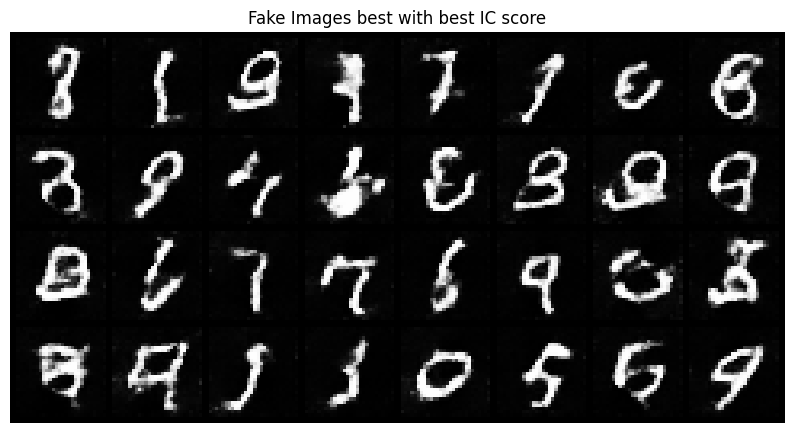

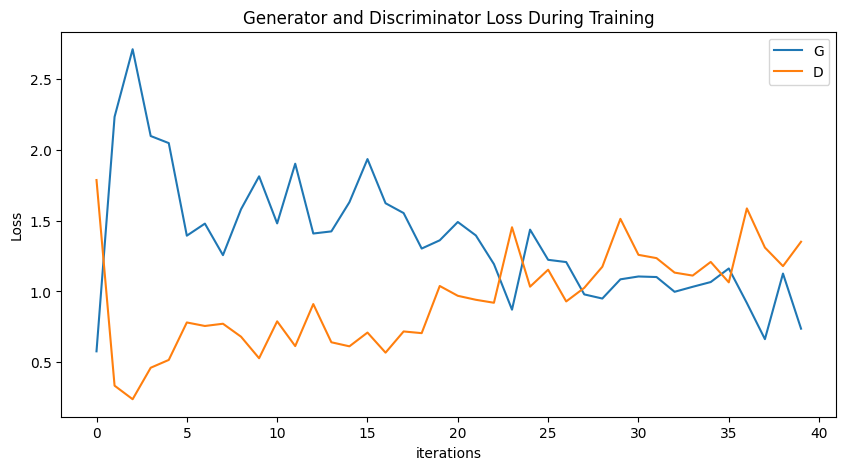

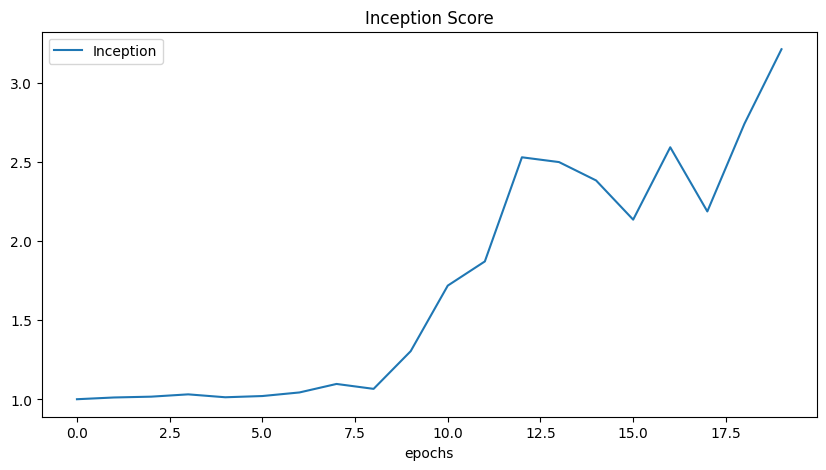

In [45]:
opt.label_smoothing =True
opt.disable_dp = False
opt.nd =5 
netG = Generator(ngpu,opt.imageSize)
netG = netG.to(device)

netG.apply(weights_init)

if opt.netG != "":
    netG.load_state_dict(torch.load(opt.netG))
netD = Discriminator(ngpu,opt.imageSize)
netD = netD.to(device)
netD.apply(weights_init)
if opt.netD != "":
    netD.load_state_dict(torch.load(opt.netD))

eval_matric = []
train_gan(netG,netD,dataloader,opt.epochs,eval_matric)
plot(eval_matric)

### Compare specefic label generator With DP_GAN original paper results


In [11]:
def plot_index(eval_matric,label):
    data = dataset.data.view(-1, 28*28).float()   # Flatten and normalize to [-1, 1]
    best_fake = [j.cpu().detach() for j in eval_matric[0][3]]
    k =3 ### top 3 nearest neighbors 
    for i in range(4):
        query_image =best_fake[i].view(-1,28*28).unsqueeze(0) # Shape: [1, 784]
        distances = torch.cdist(query_image, data, p=2)  # Shape: [1, 60000]
        distances = distances.squeeze()  # Shape: [60000]
        topk_values, topk_indices = torch.topk(distances, k=k, largest=False)
        topk_indices = topk_indices[:3]
        fig, axes = plt.subplots(1, 4, figsize=(15, 15))
        axes[0].imshow(query_image.view(28, 28), cmap='gray')
        axes[0].set_title(f'Query Image {label}')
        for i, idx in enumerate(topk_indices):
            neighbor_img = data[idx].view(28, 28)
            axes[i+1].imshow(neighbor_img, cmap='gray')
            axes[i+1].set_title(f"Neighbor {i+1}\n(Distance: {topk_values[i]:.2f})")
        plt.show()


opt.label_smoothing = False
opt.lr = 0.001
opt.nd = 5
opt.batch_size = 64
opt.epochs = 50

### Set the specfic label between 0 to 9 
opt.target_digit = 8
####
dataset2 = dataset
if (opt.target_digit!= -1):
    idx = dataset2.targets == opt.target_digit
    dataset2.targets = dataset2.targets[idx]
    dataset2.data = dataset2.data[idx]

dataloader = torch.utils.data.DataLoader(
    dataset2,
    num_workers=int(opt.workers),
    batch_size=opt.batch_size,
    shuffle=False,
)


netG = Generator(ngpu,opt.imageSize)
netG = netG.to(device)
netG.apply(weights_init)
if opt.netG != "":
    netG.load_state_dict(torch.load(opt.netG))
netD = Discriminator(ngpu,opt.imageSize)
netD = netD.to(device)
netD.apply(weights_init)
if opt.netD != "":
    netD.load_state_dict(torch.load(opt.netD))
eval_matric = []
train_gan(netG,netD,dataloader,opt.epochs,eval_matric)
plot_index(eval_matric,label=8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'train_gan' is not defined

## DP-fed-avg-gan (user-level privacy)

In [5]:


def train_gan_fed(generator, discriminator, trainloader, epochs,evaulation , gan_device,optimizerD,optimizerG,criterion,inception_score_ ):
    nz =100 
    nd = 5 
    REAL_LABEL = 0.9
    FAKE_LABEL = 0.1
    best_Inception = torch.tensor(1.0)
    G_losses,D_losses,incep_scores = [],[],[]
    num_batches = 0
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            generator.train()
            discriminator.train()
            optimizerD.zero_grad(set_to_none=True)
    
            real_data = data[0].to(gan_device)
            batch_size = real_data.size(0)
    
            # train with real
            label_true = torch.full((batch_size,), REAL_LABEL, device=gan_device)
            output = discriminator(real_data)
            errD_real = criterion(output, label_true)
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=gan_device)
            fake = generator(noise)
            label_fake = torch.full((batch_size,), FAKE_LABEL, device=gan_device)
            output = discriminator(fake.detach())
            errD_fake = criterion(output, label_fake)
    
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()
            optimizerD.zero_grad(set_to_none=True)
    
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            if (i%opt.nd != 0):
                continue
            
            optimizerG.zero_grad()
    
            label_g = torch.full((batch_size,), REAL_LABEL, device=gan_device)
            output_g = discriminator(fake)
            errG = criterion(output_g, label_g)
            errG.backward()
            optimizerG.step()

            if i % 100 == 0:
                G_losses.append(errG)
                D_losses.append(errD)
        # do checkpointing
        generator.eval()
        noise = torch.randn(batch_size*10, nz, 1, 1, device=gan_device)
        fake_distributed = generator(noise)
        incep = inception_score_(fake_distributed.detach().cpu())
        if (incep[0] > best_Inception):
            best_Inception= incep[0]
        evaulation.append(  [G_losses,D_losses,best_Inception.item()])




In [6]:
from torch.utils.data import DataLoader, Subset

import flwr as fl
from flwr.server.strategy import DifferentialPrivacyServerSideFixedClipping, FedAvg
from flwr.common import Context
from opacus.accountants.rdp import RDPAccountant
import torchvision.transforms as transforms
import numpy 
import ray
from opacus.accountants.rdp import RDPAccountant

opt.lr = 0.00009
opt.batch_size = 32
# Track privacy spending
NUM_CLIENTS = 10         # number of simulated clients
BATCH_SIZE = opt.batch_size         # batch size for local training
LOCAL_EPOCHS =10      # number of local epochs per round
NUM_ROUNDS = 30         # total number of federated rounds
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIPPING_NORM = 1    # clipping norm for DP (adjust as needed)
accountant = RDPAccountant()
noise_scale = 0.1
fraction = 0.2
sigma = (noise_scale*CLIPPING_NORM)/(fraction*NUM_CLIENTS)  #  0.1
sample_rate =fraction
delta = 1e-5


In [7]:
# Load datasets


def load_data(client_id: int, num_clients: int, batch_size: int):
    # Define the transform: convert images to tensor and normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = dset.MNIST(
        root='./data',
        download=True,
        train=True,
        transform=transforms.Compose([
            transforms.Resize(opt.imageSize,interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
    )
    
    test_dataset = dset.MNIST(
        root='./data',
        download=True,
        train=False,
        transform=transforms.Compose([
            transforms.Resize(opt.imageSize,interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
    )

    # Partition the datasets (evenly split indices among clients)
    train_indices = list(range(len(train_dataset)))
    test_indices = list(range(len(test_dataset)))
    train_splits = numpy.array_split(train_indices, num_clients)
    test_splits = numpy.array_split(test_indices, num_clients)

    train_subset = Subset(train_dataset, train_splits[client_id])
    test_subset = Subset(test_dataset, test_splits[client_id])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# ------------------------------
# Flower Client Function
# ------------------------------

def client_fn(context: Context) -> fl.client.Client:
    """
    Create a Flower client.
    The client id is used to select a partition of the dataset.
    """
    client_id = int(context.node_config["partition-id"])
    train_loader, test_loader = load_data(client_id, NUM_CLIENTS, BATCH_SIZE)
    gan = GAN( DEVICE)
    return GanClient(client_id, gan, train_loader, test_loader, local_epochs=LOCAL_EPOCHS).to_client()

# ------------------------------
# Server Strategy: DP + FedAvg
# ------------------------------


class CustomDifferentialPrivacyServerSideFixedClipping(DifferentialPrivacyServerSideFixedClipping):
    def aggregate_fit(self, server_round, results, failures):
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)
        epsilon = accountant.get_privacy_spent(delta=delta)[0]
        print(f"server_round {server_round} Privacy guarantee: (ε = {epsilon}, δ = {delta})")
        # Call the parent class's aggregate_fit method to preserve original functionality
        return super().aggregate_fit(server_round, results, failures)





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
class GAN:
    def __init__(self,  device_="cpu"):
        self.device = device_
        self.generator = Generator(1, opt.imageSize).to(device_)
        self.generator.apply(weights_init)
        self.discriminator = Discriminator(1,opt.imageSize).to(device_)
        self.discriminator.apply(weights_init)

# Helper functions to “get” and “set” model parameters (both generator and discriminator)
def get_gan_parameters(gan: GAN):
    params = []
    for p in gan.generator.parameters():
        params.append(p.detach().cpu().numpy())
    for p in gan.discriminator.parameters():
        params.append(p.detach().cpu().numpy())
    return params
def set_gan_parameters(gan: GAN, parameters):
    # Assume parameters is a list of numpy arrays in the same order as get_gan_parameters.
    gen_params = list(gan.generator.parameters())
    disc_params = list(gan.discriminator.parameters())
    total_params = gen_params + disc_params
    for p, new_val in zip(total_params, parameters):
        p.data.copy_(torch.from_numpy(new_val).to(gan.device))
        
class GanClient(fl.client.NumPyClient):
    def __init__(self, cid: str, gan: GAN, train_loader, test_loader, local_epochs=5):
        
        self.cid = cid
        self.gan = gan
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.local_epochs = local_epochs
        # Create separate optimizers for generator and discriminator
        self.optimizer_G = optim.Adam(self.gan.generator.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
        self.optimizer_D = optim.Adam(self.gan.discriminator.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
        self.adversarial_loss = nn.BCELoss().to(self.gan.device)
        self.classifier = Classifier()
        self.round = 0
        try:
            self.classifier.load_state_dict(torch.load('best_model.pth',weights_only=True))  # Corrected line
        except:
            self.classifier.load_state_dict(torch.load('/kaggle/input/best_model.pth/pytorch/default/1/best_model.pth',weights_only=True))  # Corrected line
        
        self.classifier.eval()
        for param in self.classifier.parameters():
            param.requires_grad = False
        self.inception_score  = InceptionScore(self.classifier)

    def get_parameters(self,config = 0):
        return get_gan_parameters(self.gan)
    
    def set_parameters(self, parameters):
        self.round +=1 
        set_gan_parameters(self.gan, parameters)
        
    def fit(self, parameters, config):
        
        self.set_parameters(parameters)
        self.gan.generator.train()
        self.gan.discriminator.train()
        eval_matric = []
        train_gan_fed(self.gan.generator,self.gan.discriminator,self.train_loader,self.local_epochs,eval_matric,self.gan.device, self.optimizer_G, self.optimizer_D,self.adversarial_loss,self.inception_score)
        updated_params = self.get_parameters()
        num_examples = len(self.train_loader.dataset)
        loss_G = sum([j.item() for j in eval_matric[0][0]])
        loss_D = sum([j.item() for j in eval_matric[0][1]])
        Incep_score = eval_matric[0][2]
        metrics = {"loss": float((loss_G+ loss_D)/(2*len(eval_matric[0][0]))),"inception":Incep_score}
        return updated_params, num_examples, metrics
    def evaluate(self, parameters, config):
        print(config)
        # Update local model with global parameters
        self.set_parameters(parameters)
        self.gan.generator.eval()
        self.gan.discriminator.eval()
        total_loss_eval = 0
        num_batches = 0
        REAL_LABEL = 0.9
        FAKE_LABEL = 0.1
        nz = 100
        for i, data in enumerate (self.test_loader):
            real_data = data[0].to(self.gan.device)
            batch_size = real_data.size(0)
    
            label_true = torch.full((batch_size,), REAL_LABEL, device=self.gan.device)
            output = self.gan.discriminator(real_data)
            errD_real = self.adversarial_loss(output, label_true)
            D_x = output.mean().item()

            
            noise = torch.randn(batch_size, nz, 1, 1, device=self.gan.device)
            fake = self.gan.generator(noise)
            label_fake = torch.full((batch_size,), FAKE_LABEL, device=self.gan.device)
            output = self.gan.discriminator(fake.detach())
            errD_fake = self.adversarial_loss(output, label_fake)

            loss =(( errD_real + errD_fake)/2)
            total_loss_eval += loss.item()
            num_batches += 1
        
        avg_loss = total_loss_eval / num_batches if num_batches > 0 else 0.0
        FIXED_NOISE = torch.randn(10, nz, 1, 1, device=self.gan.device)
        fake_sample = self.gan.generator(FIXED_NOISE)
        best_fake = [j.cpu().detach() for j in fake_sample]

        # vutils.save_image(
        #     fake_sample.detach(),
        #     "%s/fake_samples_%03d_%03d.png" % (opt.outf, self.cid,self.round),
        #     normalize=True,
        # )
        output_dir = "/kaggle/working/eval_images"
        plt.savefig(f"{output_dir}/round_{self.round}_client_{self.cid}.png")
        plt.close()
    
        
        fake_distributed = self.gan.generator(noise)
        num_examples = len(self.test_loader.dataset)
        noise = torch.randn(batch_size*10, nz, 1, 1, device=self.gan.device)

        fake_distributed = self.gan.generator(noise).to(self.gan.device)
        incep = self.inception_score(fake_distributed.detach().cpu())
        
        return float(avg_loss), num_examples, {"loss": avg_loss , "inception_score": incep[0].item()}

def aggregate_metrics(metrics_list):
    print(metrics_list)
    loss_values = [m["loss"] for _, m in metrics_list if "loss" in m]
    inception_values = [m["inception"] for _, m in metrics_list if "inception" in m]
    
    avg_loss = sum(loss_values) / len(loss_values) if loss_values else 0
    return {"loss": avg_loss, "inception": inception_values}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ------------------------------
# Main: Start the Simulation
# ------------------------------


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Create the base FedAvg strategy.
strategy = FedAvg(
    min_fit_clients = 1,
    min_evaluate_clients = 1,
    min_available_clients = 1 ,
    evaluate_metrics_aggregation_fn=aggregate_metrics,
    fit_metrics_aggregation_fn=aggregate_metrics,
    fraction_evaluate=fraction,
    fraction_fit = fraction
)


# Wrap the base strategy with DP fixed clipping.
dp_strategy = CustomDifferentialPrivacyServerSideFixedClipping(
    strategy,
    noise_multiplier=sigma,
    clipping_norm=CLIPPING_NORM,
    num_sampled_clients=fraction*NUM_CLIENTS,
)

metric = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=dp_strategy,
    client_resources ={"num_cpus": 1, "num_gpus": 1/NUM_CLIENTS},
)


# metric = fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
#     strategy=dp_strategy,
#     client_resources ={"num_cpus": 1, "num_gpus": 1},
# )




	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=300, no round_timeout
2025-02-02 23:35:21,538	INFO worker.py:1821 -- Started a local Ray instance.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


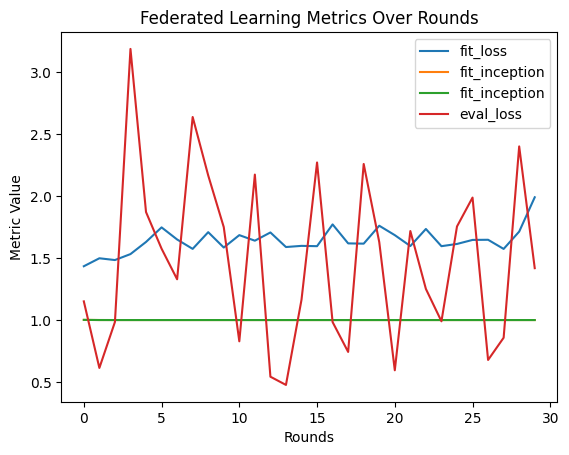

In [51]:
# Plotting the metrics
def plot_metrics(metrics):


    fit_metrics = metrics.metrics_distributed_fit
    if "loss" in fit_metrics:
        fit_loss = [round_metric[1] for round_metric in fit_metrics["loss"]]
        plt.plot(fit_loss, label='fit_loss')
    if "inception" in fit_metrics:
        fit_inception = [round_metric[1] for round_metric in fit_metrics["inception"]]
        plt.plot(fit_inception, label='fit_inception')

    
    evaluate_metrics = metrics.metrics_distributed
    if "loss" in evaluate_metrics:
        eval_loss = [round_metric[1] for round_metric in evaluate_metrics["loss"]]
        plt.plot(eval_loss, label='eval_loss')
    if "inception" in evaluate_metrics:
        eval_inception = [round_metric[1] for round_metric in evaluate_metrics["inception"]]
        plt.plot(eval_inception, label='eval_inception')
    plt.xlabel('Rounds')
    plt.ylabel('Metric Value')
    plt.title('Federated Learning Metrics Over Rounds')
    plt.legend()
    plt.show()


plot_metrics(metric)



In [15]:
# ------------------------------
# Main: Start the Simulation
# ------------------------------


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib
matplotlib.use('Agg')  # Set non-interactive backend

opt.outf = "."
opt.lr = 0.0001
opt.batch_size = 64
# Track privacy spending
NUM_CLIENTS = 10         # number of simulated clients
BATCH_SIZE = opt.batch_size         # batch size for local training
LOCAL_EPOCHS =2      # number of local epochs per round
NUM_ROUNDS = 300         # total number of federated rounds
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIPPING_NORM = 1    # clipping norm for DP (adjust as needed)
accountant = RDPAccountant()
noise_scale = 0.1
fraction = 0.4
sigma = (noise_scale*CLIPPING_NORM)/(fraction*NUM_CLIENTS)  #  0.1
sample_rate =fraction
delta = 1e-5

# Create the base FedAvg strategy.
strategy = FedAvg(
    min_fit_clients = 1,
    min_evaluate_clients = 1,
    min_available_clients = 1 ,
    evaluate_metrics_aggregation_fn=aggregate_metrics,
    fit_metrics_aggregation_fn=aggregate_metrics,
    fraction_evaluate=fraction,
    fraction_fit = fraction
)

output_dir = "/kaggle/working/eval_images"
os.makedirs(output_dir, exist_ok=True)

# Wrap the base strategy with DP fixed clipping.
dp_strategy = CustomDifferentialPrivacyServerSideFixedClipping(
    strategy,
    noise_multiplier=sigma,
    clipping_norm=CLIPPING_NORM,
    num_sampled_clients=fraction*NUM_CLIENTS,
)

metric = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=dp_strategy,
    client_resources ={"num_cpus": 1, "num_gpus": 1/(NUM_CLIENTS*fraction)},
)
plot_metrics(metric)



	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=300, no round_timeout
2025-02-02 23:32:38,298	INFO worker.py:1821 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:P100': 1.0, 'CPU': 4.0, 'object_store_memory': 8740803379.0, 'memory': 17481606759.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.25}
INFO :     

server_round 1 Privacy guarantee: (ε = 981.6990595282446, δ = 1e-05)
[(6000, {'loss': 1.1907695978879929, 'inception': 1.0016950368881226}), (6000, {'loss': 1.2616245076060295, 'inception': 1.001737356185913}), (6000, {'loss': 1.3378717824816704, 'inception': 1.0016536712646484}), (6000, {'loss': 1.364632472395897, 'inception': 1.0016067028045654})]
(ClientAppActor pid=3343) {}


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

[(1000, {'loss': 1.3193315491080284, 'inception_score': 1.001396894454956})]


(ClientAppActor pid=3343) /usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
(ClientAppActor pid=3343)   warnings.warn(*args, **kwargs)  # noqa: B028
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 2 Privacy guarantee: (ε = 1851.6198614776285, δ = 1e-05)
[(6000, {'loss': 1.5071673393249512, 'inception': 1.0013941526412964}), (6000, {'loss': 1.4191339164972305, 'inception': 1.0013673305511475}), (6000, {'loss': 1.5051499754190445, 'inception': 1.0014585256576538}), (6000, {'loss': 1.5364629551768303, 'inception': 1.0014019012451172})]
(ClientAppActor pid=3341) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

server_round 3 Privacy guarantee: (ε = 2721.5406634270125, δ = 1e-05)
[(6000, {'loss': 1.4719852358102798, 'inception': 1.0013797283172607}), (6000, {'loss': 1.4384843856096268, 'inception': 1.0014253854751587}), (6000, {'loss': 1.4961395412683487, 'inception': 1.0013667345046997}), (6000, {'loss': 1.3894674181938171, 'inception': 1.0014430284500122})]
(ClientAppActor pid=3340) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

server_round 4 Privacy guarantee: (ε = 3591.4614653763965, δ = 1e-05)
[(6000, {'loss': 1.4651965722441673, 'inception': 1.0011396408081055}), (6000, {'loss': 1.5330700054764748, 'inception': 1.0011646747589111}), (6000, {'loss': 1.4812100678682327, 'inception': 1.0011066198349}), (6000, {'loss': 1.4671903178095818, 'inception': 1.0011422634124756})]
(ClientAppActor pid=3341) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

server_round 5 Privacy guarantee: (ε = 4461.38226732578, δ = 1e-05)
[(6000, {'loss': 1.5741723477840424, 'inception': 1.0009641647338867}), (6000, {'loss': 1.5786564722657204, 'inception': 1.0010182857513428}), (6000, {'loss': 1.5935610979795456, 'inception': 1.0010793209075928}), (6000, {'loss': 1.5973922312259674, 'inception': 1.0009678602218628})]
(ClientAppActor pid=3343) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

server_round 6 Privacy guarantee: (ε = 5331.3030692751645, δ = 1e-05)
[(6000, {'loss': 1.5551466047763824, 'inception': 1.0006743669509888}), (6000, {'loss': 1.5462032109498978, 'inception': 1.0006524324417114}), (6000, {'loss': 1.554411992430687, 'inception': 1.000674843788147}), (6000, {'loss': 1.5030956715345383, 'inception': 1.0007426738739014})]
(ClientAppActor pid=3340) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

server_round 7 Privacy guarantee: (ε = 6201.223871224549, δ = 1e-05)
[(6000, {'loss': 1.4621860831975937, 'inception': 1.0008904933929443}), (6000, {'loss': 1.4240451380610466, 'inception': 1.0008193254470825}), (6000, {'loss': 1.4609504714608192, 'inception': 1.000880479812622}), (6000, {'loss': 1.406415417790413, 'inception': 1.000902771949768})]
(ClientAppActor pid=3343) {} [repeated 4x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 399, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 280, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_obje

KeyboardInterrupt: 

In [12]:
# ------------------------------
# Main: Start the Simulation
# ------------------------------


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

opt.outf = "."
opt.lr = 0.0005
opt.batch_size = 32
# Track privacy spending
NUM_CLIENTS = 10         # number of simulated clients
BATCH_SIZE = opt.batch_size         # batch size for local training
LOCAL_EPOCHS =5    # number of local epochs per round
NUM_ROUNDS = 300         # total number of federated rounds
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIPPING_NORM = 1    # clipping norm for DP (adjust as needed)
accountant = RDPAccountant()
noise_scale = 0.1
fraction = 0.4
sigma = (noise_scale*CLIPPING_NORM)/(fraction*NUM_CLIENTS)  #  0.1
sample_rate =fraction
delta = 1e-5

# Create the base FedAvg strategy.
strategy = FedAvg(
    min_fit_clients = 1,
    min_evaluate_clients = 1,
    min_available_clients = 1 ,
    evaluate_metrics_aggregation_fn=aggregate_metrics,
    fit_metrics_aggregation_fn=aggregate_metrics,
    fraction_evaluate=fraction,
    fraction_fit = fraction
)


# Wrap the base strategy with DP fixed clipping.
dp_strategy = CustomDifferentialPrivacyServerSideFixedClipping(
    strategy,
    noise_multiplier=sigma,
    clipping_norm=CLIPPING_NORM,
    num_sampled_clients=fraction*NUM_CLIENTS,
)

metric = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=dp_strategy,
    client_resources ={"num_cpus": 1, "num_gpus": 1/(NUM_CLIENTS*fraction)},
)
plot_metrics(metric)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=300, no round_timeout
2025-02-02 22:55:03,515	INFO worker.py:1821 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__int

server_round 1 Privacy guarantee: (ε = 981.6990595282446, δ = 1e-05)
[(6000, {'loss': 1.3802654802799226, 'inception': 1.0002079010009766}), (6000, {'loss': 1.356257663667202, 'inception': 1.0001914501190186}), (6000, {'loss': 1.394995078444481, 'inception': 1.0002238750457764}), (6000, {'loss': 1.4592802330851555, 'inception': 1.000199794769287})]
(ClientAppActor pid=2459) {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2692591063678265, 'inception_score': 1.0001459121704102}), (1000, {'loss': 1.271883014589548, 'inception_score': 1.000137209892273}), (1000, {'loss': 1.272265963256359, 'inception_score': 1.0001837015151978}), (1000, {'loss': 1.289605226367712, 'inception_score': 1.0001856088638306})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 2 Privacy guarantee: (ε = 1851.6198614776285, δ = 1e-05)
[(6000, {'loss': 1.3742660582065582, 'inception': 1.0001859664916992}), (6000, {'loss': 1.3556760504841805, 'inception': 1.0002037286758423}), (6000, {'loss': 1.3945000290870666, 'inception': 1.0001639127731323}), (6000, {'loss': 1.3548402309417724, 'inception': 1.000160813331604})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.4237465411424637, 'inception_score': 1.0001226663589478}), (1000, {'loss': 1.4259189143776894, 'inception_score': 1.0001932382583618}), (1000, {'loss': 1.4283047504723072, 'inception_score': 1.0001925230026245}), (1000, {'loss': 1.4302371703088284, 'inception_score': 1.0001442432403564})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 3 Privacy guarantee: (ε = 2721.5406634270125, δ = 1e-05)
[(6000, {'loss': 1.4385938674211503, 'inception': 1.000192403793335}), (6000, {'loss': 1.401548670232296, 'inception': 1.0001776218414307}), (6000, {'loss': 1.4087561324238778, 'inception': 1.0001763105392456}), (6000, {'loss': 1.3929311871528625, 'inception': 1.0001723766326904})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2178679183125496, 'inception_score': 1.0002073049545288}), (1000, {'loss': 1.2214596271514893, 'inception_score': 1.0001707077026367}), (1000, {'loss': 1.2164954915642738, 'inception_score': 1.0001637935638428}), (1000, {'loss': 1.2151976637542248, 'inception_score': 1.0001918077468872})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 4 Privacy guarantee: (ε = 3591.4614653763965, δ = 1e-05)
[(6000, {'loss': 1.3790270373225213, 'inception': 1.0001741647720337}), (6000, {'loss': 1.3657222658395767, 'inception': 1.0001709461212158}), (6000, {'loss': 1.3667168587446212, 'inception': 1.0002104043960571}), (6000, {'loss': 1.3736034765839578, 'inception': 1.0001739263534546})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.1033391207456589, 'inception_score': 1.0001403093338013}), (1000, {'loss': 1.103337787091732, 'inception_score': 1.0001713037490845}), (1000, {'loss': 1.1063127592206001, 'inception_score': 1.0001609325408936}), (1000, {'loss': 1.1049486808478832, 'inception_score': 1.0001261234283447})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 5 Privacy guarantee: (ε = 4461.38226732578, δ = 1e-05)
[(6000, {'loss': 1.356679806113243, 'inception': 1.0001362562179565}), (6000, {'loss': 1.3738201826810836, 'inception': 1.0001349449157715}), (6000, {'loss': 1.434765912592411, 'inception': 1.0001466274261475}), (6000, {'loss': 1.3978631541132926, 'inception': 1.0001367330551147})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0186679363250732, 'inception_score': 1.0001497268676758}), (1000, {'loss': 1.0194079726934433, 'inception_score': 1.0001757144927979}), (1000, {'loss': 1.018087737262249, 'inception_score': 1.0001386404037476}), (1000, {'loss': 1.0224100835621357, 'inception_score': 1.0001368522644043})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 6 Privacy guarantee: (ε = 5331.3030692751645, δ = 1e-05)
[(6000, {'loss': 1.4870468214154244, 'inception': 1.0001684427261353}), (6000, {'loss': 1.4079838663339614, 'inception': 1.000153660774231}), (6000, {'loss': 1.3143977597355843, 'inception': 1.000199556350708}), (6000, {'loss': 1.4105643019080163, 'inception': 1.000187635421753})]
(ClientAppActor pid=2460) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2461727038025856, 'inception_score': 1.0001568794250488}), (1000, {'loss': 1.246388666331768, 'inception_score': 1.0001952648162842}), (1000, {'loss': 1.2510614767670631, 'inception_score': 1.0001540184020996}), (1000, {'loss': 1.2521876506507397, 'inception_score': 1.000126838684082})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 7 Privacy guarantee: (ε = 6201.223871224549, δ = 1e-05)
[(6000, {'loss': 1.4101258248090744, 'inception': 1.0001567602157593}), (6000, {'loss': 1.4101868256926537, 'inception': 1.0001776218414307}), (6000, {'loss': 1.3909427776932717, 'inception': 1.000185251235962}), (6000, {'loss': 1.396087296307087, 'inception': 1.000182867050171})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3005619496107101, 'inception_score': 1.000125765800476}), (1000, {'loss': 1.3014542981982231, 'inception_score': 1.0001236200332642}), (1000, {'loss': 1.3015941195189953, 'inception_score': 1.0000979900360107}), (1000, {'loss': 1.3015514761209488, 'inception_score': 1.000102162361145})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 8 Privacy guarantee: (ε = 7071.1446731739325, δ = 1e-05)
[(6000, {'loss': 1.3912671104073524, 'inception': 1.0001204013824463}), (6000, {'loss': 1.3762203454971313, 'inception': 1.000106930732727}), (6000, {'loss': 1.3982879772782326, 'inception': 1.0001137256622314}), (6000, {'loss': 1.387592299282551, 'inception': 1.000105619430542})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2504284530878067, 'inception_score': 1.0000277757644653}), (1000, {'loss': 1.248810101300478, 'inception_score': 1.000025749206543}), (1000, {'loss': 1.2501777559518814, 'inception_score': 1.0000269412994385}), (1000, {'loss': 1.2498636357486248, 'inception_score': 1.0000269412994385})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 9 Privacy guarantee: (ε = 7941.065475123316, δ = 1e-05)
[(6000, {'loss': 1.388390588760376, 'inception': 1.000025987625122}), (6000, {'loss': 1.3879441618919373, 'inception': 1.0000313520431519}), (6000, {'loss': 1.3867366179823875, 'inception': 1.0000377893447876}), (6000, {'loss': 1.3806432142853737, 'inception': 1.0000333786010742})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.201970137655735, 'inception_score': 1.0000231266021729}), (1000, {'loss': 1.2003318928182125, 'inception_score': 1.0000193119049072}), (1000, {'loss': 1.2025893442332745, 'inception_score': 1.0000296831130981}), (1000, {'loss': 1.200376771390438, 'inception_score': 1.0000183582305908})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 10 Privacy guarantee: (ε = 8810.9862770727, δ = 1e-05)
[(6000, {'loss': 1.3422935754060745, 'inception': 1.0000261068344116}), (6000, {'loss': 1.4678893283009529, 'inception': 1.0000274181365967}), (6000, {'loss': 1.4396703839302063, 'inception': 1.0000275373458862}), (6000, {'loss': 1.30471530854702, 'inception': 1.0000286102294922})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.439820684492588, 'inception_score': 1.0000107288360596}), (1000, {'loss': 1.4379828050732613, 'inception_score': 1.000009536743164}), (1000, {'loss': 1.4375883415341377, 'inception_score': 1.0000157356262207}), (1000, {'loss': 1.4380976036190987, 'inception_score': 1.0000114440917969})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 11 Privacy guarantee: (ε = 9680.907079022085, δ = 1e-05)
[(6000, {'loss': 1.4400755986571312, 'inception': 1.000009536743164}), (6000, {'loss': 1.3505336314439773, 'inception': 1.0000118017196655}), (6000, {'loss': 1.361830371618271, 'inception': 1.0000100135803223}), (6000, {'loss': 1.382044230401516, 'inception': 1.0000089406967163})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2817414700984955, 'inception_score': 1.0000073909759521}), (1000, {'loss': 1.281739927828312, 'inception_score': 1.0000064373016357}), (1000, {'loss': 1.2791290581226349, 'inception_score': 1.0000070333480835}), (1000, {'loss': 1.2803931534290314, 'inception_score': 1.0000112056732178})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 12 Privacy guarantee: (ε = 10550.827880971468, δ = 1e-05)
[(6000, {'loss': 1.3712581515312194, 'inception': 1.0000075101852417}), (6000, {'loss': 1.4161443322896958, 'inception': 1.000006914138794}), (6000, {'loss': 1.3700035259127616, 'inception': 1.0000083446502686}), (6000, {'loss': 1.4205528900027276, 'inception': 1.0000064373016357})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 0.985380508005619, 'inception_score': 1.0000033378601074}), (1000, {'loss': 0.9809651877731085, 'inception_score': 1.0000053644180298}), (1000, {'loss': 0.9755779411643744, 'inception_score': 1.0000052452087402}), (1000, {'loss': 0.9791126884520054, 'inception_score': 1.0000041723251343})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 13 Privacy guarantee: (ε = 11420.748682920852, δ = 1e-05)
[(6000, {'loss': 1.2541814953088761, 'inception': 1.0000041723251343}), (6000, {'loss': 1.2631336569786071, 'inception': 1.0000041723251343}), (6000, {'loss': 1.5195136770606041, 'inception': 1.0000035762786865}), (6000, {'loss': 1.4568464204668998, 'inception': 1.0000042915344238})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.196167092770338, 'inception_score': 1.0000016689300537}), (1000, {'loss': 1.1977726072072983, 'inception_score': 1.000002145767212}), (1000, {'loss': 1.1954452581703663, 'inception_score': 1.000002145767212}), (1000, {'loss': 1.1969053894281387, 'inception_score': 1.000002145767212})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 14 Privacy guarantee: (ε = 12290.669484870237, δ = 1e-05)
[(6000, {'loss': 1.2977428555488586, 'inception': 1.0000026226043701}), (6000, {'loss': 1.3662161901593208, 'inception': 1.0000026226043701}), (6000, {'loss': 1.286611232161522, 'inception': 1.000002145767212}), (6000, {'loss': 1.3174491584300996, 'inception': 1.0000026226043701})]
(ClientAppActor pid=2461) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.1457490734755993, 'inception_score': 1.0000026226043701}), (1000, {'loss': 1.141547292470932, 'inception_score': 1.000002145767212}), (1000, {'loss': 1.1439580917358398, 'inception_score': 1.000002384185791}), (1000, {'loss': 1.1442735381424427, 'inception_score': 1.0000015497207642})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 15 Privacy guarantee: (ε = 13160.59028681962, δ = 1e-05)
[(6000, {'loss': 1.515461654961109, 'inception': 1.0000014305114746}), (6000, {'loss': 1.4468022137880325, 'inception': 1.0000017881393433}), (6000, {'loss': 1.499183975160122, 'inception': 1.0000017881393433}), (6000, {'loss': 1.4950764656066895, 'inception': 1.000002145767212})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0498475581407547, 'inception_score': 1.0000011920928955}), (1000, {'loss': 1.0322273038327694, 'inception_score': 1.0000008344650269}), (1000, {'loss': 1.0411042906343937, 'inception_score': 1.0000005960464478}), (1000, {'loss': 1.031765941530466, 'inception_score': 1.0000008344650269})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 16 Privacy guarantee: (ε = 14030.511088769004, δ = 1e-05)
[(6000, {'loss': 1.4976001679897308, 'inception': 1.0000008344650269}), (6000, {'loss': 1.2699162438511848, 'inception': 1.0000009536743164}), (6000, {'loss': 1.2657827571034432, 'inception': 1.0000007152557373}), (6000, {'loss': 1.2873618334531785, 'inception': 1.0000008344650269})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 0.9613786209374666, 'inception_score': 1.0000005960464478}), (1000, {'loss': 0.9526080973446369, 'inception_score': 1.0000007152557373}), (1000, {'loss': 0.958793057128787, 'inception_score': 1.0000007152557373}), (1000, {'loss': 0.9533097315579653, 'inception_score': 1.0000007152557373})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 17 Privacy guarantee: (ε = 14900.431890718388, δ = 1e-05)
[(6000, {'loss': 1.3146516501903533, 'inception': 1.0000007152557373}), (6000, {'loss': 1.2788608565926551, 'inception': 1.0000007152557373}), (6000, {'loss': 1.2405854895710946, 'inception': 1.0000008344650269}), (6000, {'loss': 1.4593165636062622, 'inception': 1.0000007152557373})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.180999606847763, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.170077409595251, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.1700292564928532, 'inception_score': 1.0000005960464478}), (1000, {'loss': 1.173300288617611, 'inception_score': 1.0000005960464478})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 18 Privacy guarantee: (ε = 15770.352692667771, δ = 1e-05)
[(6000, {'loss': 1.4947740882635117, 'inception': 1.0000007152557373}), (6000, {'loss': 1.3030025109648704, 'inception': 1.0000004768371582}), (6000, {'loss': 1.4790410444140434, 'inception': 1.0000007152557373}), (6000, {'loss': 1.480983278155327, 'inception': 1.0000008344650269})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.095087330788374, 'inception_score': 1.0000009536743164}), (1000, {'loss': 1.0947649292647839, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.0982464253902435, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.093226034194231, 'inception_score': 1.0000005960464478})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 19 Privacy guarantee: (ε = 16640.273494617155, δ = 1e-05)
[(6000, {'loss': 1.4926856756210327, 'inception': 1.0000011920928955}), (6000, {'loss': 1.4571852907538414, 'inception': 1.0000008344650269}), (6000, {'loss': 1.360658724606037, 'inception': 1.0000008344650269}), (6000, {'loss': 1.2958375945687295, 'inception': 1.0000009536743164})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0479551926255226, 'inception_score': 1.0000009536743164}), (1000, {'loss': 1.0593736991286278, 'inception_score': 1.0000003576278687}), (1000, {'loss': 1.043297566473484, 'inception_score': 1.0000011920928955}), (1000, {'loss': 1.040294099599123, 'inception_score': 1.000001072883606})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 20 Privacy guarantee: (ε = 17510.194296566537, δ = 1e-05)
[(6000, {'loss': 1.3769796684384346, 'inception': 1.0000008344650269}), (6000, {'loss': 1.3129978969693183, 'inception': 1.0000007152557373}), (6000, {'loss': 1.4196903556585312, 'inception': 1.0000007152557373}), (6000, {'loss': 1.323200786113739, 'inception': 1.0000011920928955})]
(ClientAppActor pid=2460) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3451653197407722, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.3492035828530788, 'inception_score': 1.0000009536743164}), (1000, {'loss': 1.3478662259876728, 'inception_score': 1.0000005960464478}), (1000, {'loss': 1.3648513182997704, 'inception_score': 1.0000007152557373})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 21 Privacy guarantee: (ε = 18380.115098515922, δ = 1e-05)
[(6000, {'loss': 1.461977806687355, 'inception': 1.0000007152557373}), (6000, {'loss': 1.3769998326897621, 'inception': 1.0000007152557373}), (6000, {'loss': 1.428655208647251, 'inception': 1.0000009536743164}), (6000, {'loss': 1.472222250699997, 'inception': 1.0000011920928955})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3222792744636536, 'inception_score': 1.0000005960464478}), (1000, {'loss': 1.3135309591889381, 'inception_score': 1.0000009536743164}), (1000, {'loss': 1.3295516893267632, 'inception_score': 1.0000008344650269}), (1000, {'loss': 1.3274975791573524, 'inception_score': 1.0000007152557373})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 22 Privacy guarantee: (ε = 19250.035900465307, δ = 1e-05)
[(6000, {'loss': 1.3795787766575813, 'inception': 1.0000007152557373}), (6000, {'loss': 1.3800362750887871, 'inception': 1.0000007152557373}), (6000, {'loss': 1.4167461425065995, 'inception': 1.0000009536743164}), (6000, {'loss': 1.4587522014975547, 'inception': 1.0000009536743164})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3413136154413223, 'inception_score': 1.0000008344650269}), (1000, {'loss': 1.3383694365620613, 'inception_score': 1.0000005960464478}), (1000, {'loss': 1.3182368539273739, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.3121698945760727, 'inception_score': 1.0000004768371582})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 23 Privacy guarantee: (ε = 20119.95670241469, δ = 1e-05)
[(6000, {'loss': 1.4665332406759262, 'inception': 1.0000005960464478}), (6000, {'loss': 1.430494074523449, 'inception': 1.0000005960464478}), (6000, {'loss': 1.4640593886375428, 'inception': 1.0000005960464478}), (6000, {'loss': 1.4053120166063309, 'inception': 1.0000007152557373})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.6046583466231823, 'inception_score': 1.0000050067901611}), (1000, {'loss': 1.59868373721838, 'inception_score': 1.000004529953003}), (1000, {'loss': 1.5966136381030083, 'inception_score': 1.0000054836273193}), (1000, {'loss': 1.5977307222783566, 'inception_score': 1.000002145767212})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 24 Privacy guarantee: (ε = 20989.877504364074, δ = 1e-05)
[(6000, {'loss': 1.4649869173765182, 'inception': 1.0000040531158447}), (6000, {'loss': 1.4907217144966125, 'inception': 1.000003695487976}), (6000, {'loss': 1.492037558555603, 'inception': 1.000003695487976}), (6000, {'loss': 1.5214676946401595, 'inception': 1.0000040531158447})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2541339062154293, 'inception_score': 1.000007152557373}), (1000, {'loss': 1.2474302537739277, 'inception_score': 1.0000052452087402}), (1000, {'loss': 1.2521433420479298, 'inception_score': 1.000007152557373}), (1000, {'loss': 1.2439371533691883, 'inception_score': 1.0000081062316895})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 25 Privacy guarantee: (ε = 21859.79830631346, δ = 1e-05)
[(6000, {'loss': 1.4708649948239327, 'inception': 1.0000072717666626}), (6000, {'loss': 1.454461507499218, 'inception': 1.0000063180923462}), (6000, {'loss': 1.5066681250929832, 'inception': 1.0000067949295044}), (6000, {'loss': 1.4642231523990632, 'inception': 1.0000078678131104})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.378368727862835, 'inception_score': 1.000015377998352}), (1000, {'loss': 1.375413242727518, 'inception_score': 1.0000096559524536}), (1000, {'loss': 1.358891848474741, 'inception_score': 1.000011920928955}), (1000, {'loss': 1.355989959090948, 'inception_score': 1.0000085830688477})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 26 Privacy guarantee: (ε = 22729.71910826284, δ = 1e-05)
[(6000, {'loss': 1.4493628814816475, 'inception': 1.0000147819519043}), (6000, {'loss': 1.4384603083133698, 'inception': 1.0000110864639282}), (6000, {'loss': 1.4932837039232254, 'inception': 1.0000154972076416}), (6000, {'loss': 1.5161827474832534, 'inception': 1.0000113248825073})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.4398941732943058, 'inception_score': 1.000017523765564}), (1000, {'loss': 1.4278785735368729, 'inception_score': 1.000012993812561}), (1000, {'loss': 1.4446501061320305, 'inception_score': 1.0000112056732178}), (1000, {'loss': 1.4142169617116451, 'inception_score': 1.0000154972076416})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 27 Privacy guarantee: (ε = 23599.639910212227, δ = 1e-05)
[(6000, {'loss': 1.519977056980133, 'inception': 1.0000131130218506}), (6000, {'loss': 1.5376104518771172, 'inception': 1.0000114440917969}), (6000, {'loss': 1.4999340161681176, 'inception': 1.0000123977661133}), (6000, {'loss': 1.477607400715351, 'inception': 1.0000110864639282})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.372875440865755, 'inception_score': 1.0000091791152954}), (1000, {'loss': 1.3786822408437729, 'inception_score': 1.0000182390213013}), (1000, {'loss': 1.3908934630453587, 'inception_score': 1.0000102519989014}), (1000, {'loss': 1.377396896481514, 'inception_score': 1.0000109672546387})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 28 Privacy guarantee: (ε = 24469.560712161612, δ = 1e-05)
[(6000, {'loss': 1.462156668305397, 'inception': 1.0000110864639282}), (6000, {'loss': 1.4575439527630807, 'inception': 1.000011682510376}), (6000, {'loss': 1.4629388645291328, 'inception': 1.0000107288360596}), (6000, {'loss': 1.4817853659391402, 'inception': 1.00001060962677})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3386762291193008, 'inception_score': 1.000024437904358}), (1000, {'loss': 1.3434290066361427, 'inception_score': 1.0000165700912476}), (1000, {'loss': 1.3203707337379456, 'inception_score': 1.0000193119049072}), (1000, {'loss': 1.3181698061525822, 'inception_score': 1.0000180006027222})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 29 Privacy guarantee: (ε = 25339.481514110994, δ = 1e-05)
[(6000, {'loss': 1.5106682002544403, 'inception': 1.0000184774398804}), (6000, {'loss': 1.4808123633265495, 'inception': 1.0000191926956177}), (6000, {'loss': 1.5301464945077896, 'inception': 1.00002121925354}), (6000, {'loss': 1.4828971207141877, 'inception': 1.0000216960906982})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2160487994551659, 'inception_score': 1.0000184774398804}), (1000, {'loss': 1.2387083061039448, 'inception_score': 1.000012755393982}), (1000, {'loss': 1.2210393659770489, 'inception_score': 1.0000110864639282}), (1000, {'loss': 1.2237240187823772, 'inception_score': 1.0000163316726685})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 30 Privacy guarantee: (ε = 26209.40231606038, δ = 1e-05)
[(6000, {'loss': 1.5225880816578865, 'inception': 1.0000183582305908}), (6000, {'loss': 1.471676829457283, 'inception': 1.0000163316726685}), (6000, {'loss': 1.4560908451676369, 'inception': 1.0000152587890625}), (6000, {'loss': 1.4309472799301148, 'inception': 1.000012755393982})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.1595941707491875, 'inception_score': 1.0000104904174805}), (1000, {'loss': 1.171914204955101, 'inception_score': 1.0000110864639282}), (1000, {'loss': 1.1604308150708675, 'inception_score': 1.0000120401382446}), (1000, {'loss': 1.1601192653179169, 'inception_score': 1.0000107288360596})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 31 Privacy guarantee: (ε = 27079.32311800976, δ = 1e-05)
[(6000, {'loss': 1.496496820449829, 'inception': 1.0000146627426147}), (6000, {'loss': 1.4761330097913743, 'inception': 1.0000107288360596}), (6000, {'loss': 1.4365782260894775, 'inception': 1.0000123977661133}), (6000, {'loss': 1.4261974543333054, 'inception': 1.0000125169754028})]
(ClientAppActor pid=2460) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0531223081052303, 'inception_score': 1.0000104904174805}), (1000, {'loss': 1.0318836215883493, 'inception_score': 1.0000120401382446}), (1000, {'loss': 1.0349417962133884, 'inception_score': 1.0000110864639282}), (1000, {'loss': 1.0401666462421417, 'inception_score': 1.0000073909759521})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 32 Privacy guarantee: (ε = 27949.243919959146, δ = 1e-05)
[(6000, {'loss': 1.4037915080785752, 'inception': 1.0000107288360596}), (6000, {'loss': 1.3990556284785272, 'inception': 1.0000087022781372}), (6000, {'loss': 1.4930859878659248, 'inception': 1.000008225440979}), (6000, {'loss': 1.4670703902840614, 'inception': 1.0000109672546387})]
(ClientAppActor pid=2460) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.1195849291980267, 'inception_score': 1.0000039339065552}), (1000, {'loss': 1.114037036895752, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.1358946450054646, 'inception_score': 1.0000027418136597}), (1000, {'loss': 1.1140505708754063, 'inception_score': 1.0000029802322388})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 33 Privacy guarantee: (ε = 28819.16472190853, δ = 1e-05)
[(6000, {'loss': 1.3843074709177017, 'inception': 1.0000042915344238}), (6000, {'loss': 1.4479726612567902, 'inception': 1.000004529953003}), (6000, {'loss': 1.401054434478283, 'inception': 1.0000038146972656}), (6000, {'loss': 1.3840342894196511, 'inception': 1.0000028610229492})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3291483335196972, 'inception_score': 1.0000035762786865}), (1000, {'loss': 1.3374828323721886, 'inception_score': 1.0000030994415283}), (1000, {'loss': 1.32628383487463, 'inception_score': 1.0000035762786865}), (1000, {'loss': 1.3226253427565098, 'inception_score': 1.0000044107437134})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 34 Privacy guarantee: (ε = 29689.085523857913, δ = 1e-05)
[(6000, {'loss': 1.395874547958374, 'inception': 1.0000039339065552}), (6000, {'loss': 1.3592361494898797, 'inception': 1.0000050067901611}), (6000, {'loss': 1.3669017404317856, 'inception': 1.0000035762786865}), (6000, {'loss': 1.4423938408493995, 'inception': 1.0000050067901611})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3445952981710434, 'inception_score': 1.0000033378601074}), (1000, {'loss': 1.3447221145033836, 'inception_score': 1.0000028610229492}), (1000, {'loss': 1.3429523147642612, 'inception_score': 1.0000039339065552}), (1000, {'loss': 1.3478226140141487, 'inception_score': 1.0000032186508179})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 35 Privacy guarantee: (ε = 30559.0063258073, δ = 1e-05)
[(6000, {'loss': 1.3338454753160476, 'inception': 1.0000035762786865}), (6000, {'loss': 1.4338638082146644, 'inception': 1.0000041723251343}), (6000, {'loss': 1.3929186642169953, 'inception': 1.0000039339065552}), (6000, {'loss': 1.3806765720248222, 'inception': 1.0000054836273193})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0564589984714985, 'inception_score': 1.0000020265579224}), (1000, {'loss': 1.0663090273737907, 'inception_score': 1.0000017881393433}), (1000, {'loss': 1.0636663623154163, 'inception_score': 1.0000017881393433}), (1000, {'loss': 1.0473485998809338, 'inception_score': 1.0000015497207642})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 36 Privacy guarantee: (ε = 31428.92712775668, δ = 1e-05)
[(6000, {'loss': 1.446813812851906, 'inception': 1.0000017881393433}), (6000, {'loss': 1.3463373854756355, 'inception': 1.000002145767212}), (6000, {'loss': 1.451899465918541, 'inception': 1.0000017881393433}), (6000, {'loss': 1.4169556379318238, 'inception': 1.0000017881393433})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2540247030556202, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.2498645633459091, 'inception_score': 1.0000059604644775}), (1000, {'loss': 1.2635613232851028, 'inception_score': 1.000004768371582}), (1000, {'loss': 1.2582823634147644, 'inception_score': 1.0000051259994507})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 37 Privacy guarantee: (ε = 32298.847929706066, δ = 1e-05)
[(6000, {'loss': 1.4182693645358087, 'inception': 1.0000044107437134}), (6000, {'loss': 1.4232470616698265, 'inception': 1.0000050067901611}), (6000, {'loss': 1.3775429829955101, 'inception': 1.000004529953003}), (6000, {'loss': 1.4098329275846482, 'inception': 1.0000040531158447})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.0260094851255417, 'inception_score': 1.000003695487976}), (1000, {'loss': 1.015666401013732, 'inception_score': 1.0000033378601074}), (1000, {'loss': 1.0207143500447273, 'inception_score': 1.000003457069397}), (1000, {'loss': 1.0306158624589443, 'inception_score': 1.000002384185791})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 38 Privacy guarantee: (ε = 33168.76873165545, δ = 1e-05)
[(6000, {'loss': 1.3117198377847672, 'inception': 1.0000035762786865}), (6000, {'loss': 1.3596516028046608, 'inception': 1.0000030994415283}), (6000, {'loss': 1.4175397336483002, 'inception': 1.0000040531158447}), (6000, {'loss': 1.4296367913484573, 'inception': 1.0000028610229492})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.1024753078818321, 'inception_score': 1.0000032186508179}), (1000, {'loss': 1.1007561460137367, 'inception_score': 1.0000025033950806}), (1000, {'loss': 1.09837207198143, 'inception_score': 1.0000030994415283}), (1000, {'loss': 1.1133044846355915, 'inception_score': 1.0000039339065552})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 39 Privacy guarantee: (ε = 34038.68953360483, δ = 1e-05)
[(6000, {'loss': 1.4264853104948998, 'inception': 1.0000035762786865}), (6000, {'loss': 1.4391351863741875, 'inception': 1.0000030994415283}), (6000, {'loss': 1.2997567027807235, 'inception': 1.0000025033950806}), (6000, {'loss': 1.3803235203027726, 'inception': 1.0000033378601074})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.6031698510050774, 'inception_score': 1.0000029802322388}), (1000, {'loss': 1.6036847233772278, 'inception_score': 1.0000048875808716}), (1000, {'loss': 1.6022902242839336, 'inception_score': 1.0000054836273193}), (1000, {'loss': 1.6052009798586369, 'inception_score': 1.000006079673767})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 40 Privacy guarantee: (ε = 34908.610335554215, δ = 1e-05)
[(6000, {'loss': 1.4328381955623626, 'inception': 1.0000033378601074}), (6000, {'loss': 1.4365585759282111, 'inception': 1.000004768371582}), (6000, {'loss': 1.3985304534435272, 'inception': 1.0000048875808716}), (6000, {'loss': 1.3979658767580987, 'inception': 1.000004529953003})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2836487889289856, 'inception_score': 1.0000048875808716}), (1000, {'loss': 1.2833893671631813, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.2822024449706078, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.2858729138970375, 'inception_score': 1.0000030994415283})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 41 Privacy guarantee: (ε = 35778.5311375036, δ = 1e-05)
[(6000, {'loss': 1.4137668386101723, 'inception': 1.0000030994415283}), (6000, {'loss': 1.4112873524427414, 'inception': 1.0000054836273193}), (6000, {'loss': 1.3421930715441703, 'inception': 1.000004529953003}), (6000, {'loss': 1.3945908010005952, 'inception': 1.000004768371582})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.238268531858921, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.234404545277357, 'inception_score': 1.000003695487976}), (1000, {'loss': 1.233455128967762, 'inception_score': 1.0000029802322388}), (1000, {'loss': 1.2321293875575066, 'inception_score': 1.0000029802322388})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 42 Privacy guarantee: (ε = 36648.451939452985, δ = 1e-05)
[(6000, {'loss': 1.350687488913536, 'inception': 1.0000040531158447}), (6000, {'loss': 1.3649206385016441, 'inception': 1.0000033378601074}), (6000, {'loss': 1.3537313118577003, 'inception': 1.0000041723251343}), (6000, {'loss': 1.3832106560468673, 'inception': 1.0000041723251343})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.3887556083500385, 'inception_score': 1.0000050067901611}), (1000, {'loss': 1.3820715583860874, 'inception_score': 1.0000035762786865}), (1000, {'loss': 1.383311565965414, 'inception_score': 1.0000040531158447}), (1000, {'loss': 1.3841026052832603, 'inception_score': 1.0000035762786865})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 43 Privacy guarantee: (ε = 37518.37274140237, δ = 1e-05)
[(6000, {'loss': 1.4072330743074417, 'inception': 1.0000033378601074}), (6000, {'loss': 1.3905750647187234, 'inception': 1.0000027418136597}), (6000, {'loss': 1.3415792882442474, 'inception': 1.0000035762786865}), (6000, {'loss': 1.3731619998812676, 'inception': 1.0000048875808716})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.2411020882427692, 'inception_score': 1.0000014305114746}), (1000, {'loss': 1.2456297725439072, 'inception_score': 1.0000014305114746}), (1000, {'loss': 1.2411059141159058, 'inception_score': 1.0000022649765015}), (1000, {'loss': 1.2419262751936913, 'inception_score': 1.0000011920928955})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 44 Privacy guarantee: (ε = 38388.293543351756, δ = 1e-05)
[(6000, {'loss': 1.4155917197465897, 'inception': 1.0000019073486328}), (6000, {'loss': 1.4141329139471055, 'inception': 1.000002145767212}), (6000, {'loss': 1.3539464741945266, 'inception': 1.000001311302185}), (6000, {'loss': 1.4065598264336585, 'inception': 1.000002145767212})]
(ClientAppActor pid=2459) {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 10)


[(1000, {'loss': 1.132326152175665, 'inception_score': 1.0000009536743164}), (1000, {'loss': 1.1359650567173958, 'inception_score': 1.0000007152557373}), (1000, {'loss': 1.1314534917473793, 'inception_score': 1.0000014305114746}), (1000, {'loss': 1.1288666166365147, 'inception_score': 1.000001072883606})]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.0063 stdev added
INFO :      configure_evaluate: strategy sampled 4 clients (out of 10)


server_round 45 Privacy guarantee: (ε = 39258.21434530114, δ = 1e-05)
[(6000, {'loss': 1.4465570747852325, 'inception': 1.0000011920928955}), (6000, {'loss': 1.4096832811832427, 'inception': 1.0000011920928955}), (6000, {'loss': 1.3592031747102737, 'inception': 1.000001311302185}), (6000, {'loss': 1.3751714169979095, 'inception': 1.000001311302185})]
(ClientAppActor pid=2462) {} [repeated 4x across cluster]


KeyboardInterrupt: 